In [1]:
# imports
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import seaborn as sns

In [2]:
# importing custom helper function for later
%run -i "tz_imputation.py"
%run -i "street_type_abbr.py"

In [3]:
# turning off this annoying warning thing
pd.options.mode.chained_assignment = None

# Task 1.1: Data Preparation

In [4]:
# loading csvs
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [5]:
# quick check on the dataframe
test_df.head()

,ID,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3056781,2020-12-15 18:06:30,2020-12-16 03:35:30,33.708096,-117.780277,33.733073,-117.814465,2.615,NaN,I-5 N,...,False,False,False,False,False,False,Night,Night,Night,Day
1,A-3861069,2019-09-25 17:57:00,2019-09-25 19:18:45,37.660428,-122.403812,37.660428,-122.403812,0.000,NaN,Bayshore Fwy N,...,False,True,False,False,False,False,Day,Day,Day,Day
2,A-3283070,2020-11-06 18:57:10,2020-11-06 21:32:23,45.647664,-111.351367,45.648531,-111.351319,0.060,NaN,Axtell Anceny Rd,...,False,False,False,False,False,False,Night,Night,Night,Night
3,A-3207908,2020-11-02 14:25:39,2020-11-02 16:25:42,40.207033,-76.219940,40.210121,-76.220782,0.218,1.0,Wood Corner Rd,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-4128825,2017-10-03 09:07:42,2017-10-03 15:07:42,29.814050,-95.360610,29.814020,-95.366040,0.326,NaN,I-610 W,...,False,False,False,False,False,False,Day,Day,Day,Day


In [6]:
# quick check on numerical values
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Start_Lat,151607.0,36.934057,5.157855,24.571536,33.863220,37.398720,40.732995,48.966338
Start_Lng,151607.0,-98.627880,18.530823,-124.497523,-118.214389,-94.409678,-80.861295,-67.614387
End_Lat,151607.0,36.934102,5.157750,24.571534,33.862350,37.398860,40.733250,48.966444
End_Lng,151607.0,-98.627790,18.530730,-124.497442,-118.214270,-94.407950,-80.861294,-67.620340
Distance(mi),151607.0,0.579563,1.655603,0.000000,0.000000,0.175000,0.588000,152.543000
Number,47082.0,9027.147466,18236.423389,0.000000,1210.250000,4000.000000,10198.750000,850900.000000
Temperature(F),147262.0,59.603283,18.253417,-26.000000,48.000000,61.000000,73.000000,129.200000
Wind_Chill(F),106699.0,55.131328,21.126875,-53.500000,41.000000,57.000000,71.000000,110.000000
Humidity(%),147023.0,64.671004,23.231855,1.000000,48.000000,67.000000,84.000000,100.000000
Pressure(in),147969.0,29.555832,1.013628,19.910000,29.440000,29.880000,30.040000,57.740000


In [7]:
# quick check on the dataframe
train_df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3145301,2,2020-12-17 13:56:30,2020-12-18 00:21:16,25.939703,-80.188672,25.941481,-80.190011,0.148,17909.0,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2906919,4,2017-04-27 14:31:24,2017-04-27 20:31:24,43.197700,-89.324430,43.190950,-89.324640,0.467,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3334868,2,2020-12-29 00:22:00,2020-12-29 02:00:37,33.928147,-117.880283,33.922082,-117.880314,0.419,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
3,A-3842156,2,2019-11-12 15:41:00,2019-11-12 17:29:58,40.717830,-111.953630,40.717830,-111.953630,0.000,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-3680462,2,2020-01-10 19:22:13,2020-01-10 23:22:13,44.008170,-123.725830,44.008170,-123.725830,0.000,15683.0,...,False,False,False,False,False,False,Night,Night,Night,Night


In [8]:
# quick check on numerical values
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Severity,454819.0,2.237798,0.607124,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,454819.0,36.889425,5.172987,24.570222,33.853450,37.336563,40.725746,49.000560
Start_Lng,454819.0,-98.565505,18.491487,-124.497567,-118.204979,-94.196830,-80.868365,-67.403551
End_Lat,454819.0,36.889509,5.172990,24.570110,33.853276,37.336621,40.725860,49.000760
End_Lng,454819.0,-98.565346,18.491330,-124.497478,-118.205073,-94.193390,-80.869045,-67.403550
Distance(mi),454819.0,0.588083,1.624705,0.000000,0.000000,0.178000,0.595000,150.138000
Number,140896.0,8947.184739,17752.126698,1.000000,1213.000000,4001.000000,10103.250000,851900.000000
Temperature(F),441909.0,59.570331,18.277158,-89.000000,47.000000,61.000000,73.000000,168.800000
Wind_Chill(F),319861.0,55.119312,21.137370,-89.000000,40.700000,57.000000,71.000000,111.000000
Humidity(%),441149.0,64.651394,23.288213,1.000000,48.000000,68.000000,84.000000,100.000000


In [9]:
# quick check on the dataframe
val_df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3133992,2,2020-12-24 22:04:00,2020-12-25 00:39:00,29.517217,-98.396312,29.491863,-98.401992,1.785,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-4114587,3,2017-12-23 22:55:00,2017-12-24 04:55:00,45.494570,-122.673590,45.487430,-122.678580,0.549,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3985478,4,2018-10-20 15:32:59,2018-10-20 16:02:36,42.702751,-84.548020,42.700873,-84.548030,0.130,468.0,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-3913907,2,2019-02-21 17:05:14,2019-02-21 17:35:13,42.328963,-83.215750,42.326412,-83.215645,0.176,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-3457977,2,2020-06-01 18:25:57,2020-06-01 18:40:57,33.773500,-84.235190,33.773500,-84.235190,0.000,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day


In [10]:
# quick check on numerical values
val_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Severity,151606.0,2.240538,0.608165,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,151606.0,36.920080,5.151439,24.570584,33.856873,37.378529,40.727600,48.991585
Start_Lng,151606.0,-98.569743,18.494650,-124.497410,-118.207620,-94.355470,-80.865664,-67.868380
End_Lat,151606.0,36.920071,5.151362,24.574546,33.856757,37.378220,40.727738,49.002140
End_Lng,151606.0,-98.569519,18.494490,-124.497410,-118.207676,-94.356550,-80.865379,-67.868490
Distance(mi),151606.0,0.589541,1.715037,0.000000,0.000000,0.180000,0.594000,153.663000
Number,46791.0,8782.533244,15498.826046,1.000000,1205.000000,3998.000000,10099.000000,611963.000000
Temperature(F),147294.0,59.593157,18.336775,-58.000000,47.000000,61.000000,73.000000,170.600000
Wind_Chill(F),106459.0,55.044042,21.181972,-65.900000,40.600000,57.000000,71.000000,112.000000
Humidity(%),147061.0,64.610883,23.268737,1.000000,48.000000,67.000000,84.000000,100.000000


In [11]:
# dropping redundant ID column
train_df = train_df.drop("ID", axis=1)
val_df = val_df.drop("ID", axis=1)

In [12]:
# original dataframe without cleaning but no ID column in case we need it
orig_train_df = train_df.copy()
orig_val_df = val_df.copy()
orig_test_df = test_df.copy()

## Data Cleaning (same as assignment 1)
### -- Severity (the label)

In [13]:
# no need to check test set for this one as they don't have the label
print(train_df['Severity'].value_counts())
print(val_df['Severity'].value_counts())

2    364027
3     48187
4     34191
1      8414
Name: Severity, dtype: int64
2    121312
3     16105
4     11517
1      2672
Name: Severity, dtype: int64


In [14]:
# check for nulls
print(train_df['Severity'].isna().sum())
print(val_df['Severity'].isna().sum())

0
0


### -- Start_Time, End_Time

In [15]:
print(train_df['Start_Time'])
train_df['End_Time']

0         2020-12-17 13:56:30
1         2017-04-27 14:31:24
2         2020-12-29 00:22:00
3         2019-11-12 15:41:00
4         2020-01-10 19:22:13
                 ...         
454814    2020-05-20 16:43:48
454815    2020-11-07 02:56:31
454816    2017-05-25 05:53:09
454817    2017-01-19 17:47:52
454818    2017-10-05 15:37:55
Name: Start_Time, Length: 454819, dtype: object


0         2020-12-18 00:21:16
1         2017-04-27 20:31:24
2         2020-12-29 02:00:37
3         2019-11-12 17:29:58
4         2020-01-10 23:22:13
                 ...         
454814    2020-05-20 17:13:48
454815    2020-11-07 08:34:51
454816    2017-05-25 11:53:09
454817    2017-01-19 23:47:52
454818    2017-10-05 21:37:55
Name: End_Time, Length: 454819, dtype: object

In [16]:
# no need to check value counts as they have a lot of uniques
# checking nulls
print(train_df['Start_Time'].isna().sum())
print(val_df['Start_Time'].isna().sum())
print(test_df['Start_Time'].isna().sum())
print(train_df['End_Time'].isna().sum())
print(val_df['End_Time'].isna().sum())
print(test_df['End_Time'].isna().sum())

0
0
0
0
0
0


In [17]:
# scrolling through the CSV, we can see that some timestamp has a microseconds part
# since truncating those microseconds won't affect things much
# let's remove it for the next steps

# regex will check for strings with 19 characters and has a microseconds after it
regex_str = '(.{19}).\d+'

# turn off some dumb warnings for this one
with warnings.catch_warnings(record=True):
    # pre-removal
    # True means the timestamp has a microsecond part, False means it doesn't
    print(train_df['Start_Time'].str.contains(regex_str).value_counts())
    print(val_df['Start_Time'].str.contains(regex_str).value_counts())
    print(test_df['Start_Time'].str.contains(regex_str).value_counts())
    print(train_df['End_Time'].str.contains(regex_str).value_counts())
    print(val_df['End_Time'].str.contains(regex_str).value_counts())
    print(test_df['End_Time'].str.contains(regex_str).value_counts())

    # cut the string to only the first 19 characters if the length is longer than 19
    train_df['Start_Time'] = train_df['Start_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)
    val_df['Start_Time'] = val_df['Start_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)
    test_df['Start_Time'] = test_df['Start_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)
    train_df['End_Time'] = train_df['End_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)
    val_df['End_Time'] = val_df['End_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)
    test_df['End_Time'] = test_df['End_Time'].apply(lambda x : x[:19] if len(x) > 19 else x)

False    444405
True      10414
Name: Start_Time, dtype: int64
False    148167
True       3439
Name: Start_Time, dtype: int64
False    148206
True       3401
Name: Start_Time, dtype: int64
False    444405
True      10414
Name: End_Time, dtype: int64
False    148167
True       3439
Name: End_Time, dtype: int64
False    148206
True       3401
Name: End_Time, dtype: int64


In [18]:
# turn off some dumb warnings for this one
with warnings.catch_warnings(record=True):
    # post-removal
    print(train_df['Start_Time'].str.contains(regex_str).value_counts())
    print(val_df['Start_Time'].str.contains(regex_str).value_counts())
    print(test_df['Start_Time'].str.contains(regex_str).value_counts())
    print(train_df['End_Time'].str.contains(regex_str).value_counts())
    print(val_df['End_Time'].str.contains(regex_str).value_counts())
    print(test_df['End_Time'].str.contains(regex_str).value_counts())


False    454819
Name: Start_Time, dtype: int64
False    151606
Name: Start_Time, dtype: int64
False    151607
Name: Start_Time, dtype: int64
False    454819
Name: End_Time, dtype: int64
False    151606
Name: End_Time, dtype: int64
False    151607
Name: End_Time, dtype: int64


In [19]:
# sanity check
print(train_df['Start_Time'].value_counts())

# I did a Ctrl+F for "2020-12-16 13:53:25" and 33 matches showed up, and some has the microseconds part
# so value_counts() showing up with 33 matches means it is correct

2020-12-16 13:53:25    33
2020-09-30 12:41:30    22
2017-05-15 09:22:55    21
2020-12-15 02:32:00    20
2019-10-26 08:45:17    19
                       ..
2019-09-09 08:52:57     1
2020-12-07 16:07:38     1
2019-09-23 14:28:00     1
2019-01-02 07:06:42     1
2017-10-05 15:37:55     1
Name: Start_Time, Length: 385204, dtype: int64


In [20]:
# converting from string to a float unix timestamp
# this makes the data more "readable" and understandable for the machine
format_str = "%Y-%m-%d %H:%M:%S"
datetime_obj = dt.datetime

train_df['Start_Time'] = train_df['Start_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())
val_df['Start_Time'] = val_df['Start_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())
test_df['Start_Time'] = test_df['Start_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())
train_df['End_Time'] = train_df['End_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())
val_df['End_Time'] = val_df['End_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())
test_df['End_Time'] = test_df['End_Time'].apply(lambda t : datetime_obj.strptime(t, format_str).timestamp())

train_df['Start_Time']


0         1.608188e+09
1         1.493278e+09
2         1.609176e+09
3         1.573548e+09
4         1.578659e+09
              ...     
454814    1.589968e+09
454815    1.604693e+09
454816    1.495666e+09
454817    1.484823e+09
454818    1.507193e+09
Name: Start_Time, Length: 454819, dtype: float64

### -- Start_Lat, Start_Lng, End_Lat, End_Lng

In [21]:
print(train_df['Start_Lat'].head())
print(train_df['Start_Lng'].head())
print(train_df['End_Lat'].head())
print(train_df['End_Lng'].head())

0    25.939703
1    43.197700
2    33.928147
3    40.717830
4    44.008170
Name: Start_Lat, dtype: float64
0    -80.188672
1    -89.324430
2   -117.880283
3   -111.953630
4   -123.725830
Name: Start_Lng, dtype: float64
0    25.941481
1    43.190950
2    33.922082
3    40.717830
4    44.008170
Name: End_Lat, dtype: float64
0    -80.190011
1    -89.324640
2   -117.880314
3   -111.953630
4   -123.725830
Name: End_Lng, dtype: float64


In [22]:
print(train_df['Start_Lat'].isna().sum())
print(train_df['Start_Lng'].isna().sum())
print(train_df['End_Lat'].isna().sum())
print(train_df['End_Lng'].isna().sum())

0
0
0
0


* Assuming the dataset only contains accidents that happen inside the Contiguous Mainland United States (meaning excluding Alaska, Hawaii and other territories and islands) and according to [here](https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_States). 
* The lowest latitude point is 24.44, the highest latitude point is 49.38
* The lowest longitude point is -124.79, the highest longitude point is -66.95
* So any latitude or longitude out of this range is considered an impossible value

In [23]:
# luckily we don't have any impossible value to deal with
print(train_df['Start_Lat'].describe()[['min', 'max']])
print(train_df['Start_Lng'].describe()[['min', 'max']])
print(train_df['End_Lat'].describe()[['min', 'max']])
print(train_df['End_Lng'].describe()[['min', 'max']])

min    24.570222
max    49.000560
Name: Start_Lat, dtype: float64
min   -124.497567
max    -67.403551
Name: Start_Lng, dtype: float64
min    24.57011
max    49.00076
Name: End_Lat, dtype: float64
min   -124.497478
max    -67.403550
Name: End_Lng, dtype: float64


### -- Distance(mi)

In [24]:
train_df["Distance(mi)"]

0         0.148
1         0.467
2         0.419
3         0.000
4         0.000
          ...  
454814    1.010
454815    4.311
454816    0.109
454817    0.001
454818    0.038
Name: Distance(mi), Length: 454819, dtype: float64

In [25]:
train_df["Distance(mi)"].isna().sum()

0

In [26]:
print(train_df["Distance(mi)"].describe())
print(val_df["Distance(mi)"].describe())
print(test_df["Distance(mi)"].describe())

count    454819.000000
mean          0.588083
std           1.624705
min           0.000000
25%           0.000000
50%           0.178000
75%           0.595000
max         150.138000
Name: Distance(mi), dtype: float64
count    151606.000000
mean          0.589541
std           1.715037
min           0.000000
25%           0.000000
50%           0.180000
75%           0.594000
max         153.663000
Name: Distance(mi), dtype: float64
count    151607.000000
mean          0.579563
std           1.655603
min           0.000000
25%           0.000000
50%           0.175000
75%           0.588000
max         152.543000
Name: Distance(mi), dtype: float64


<AxesSubplot:>

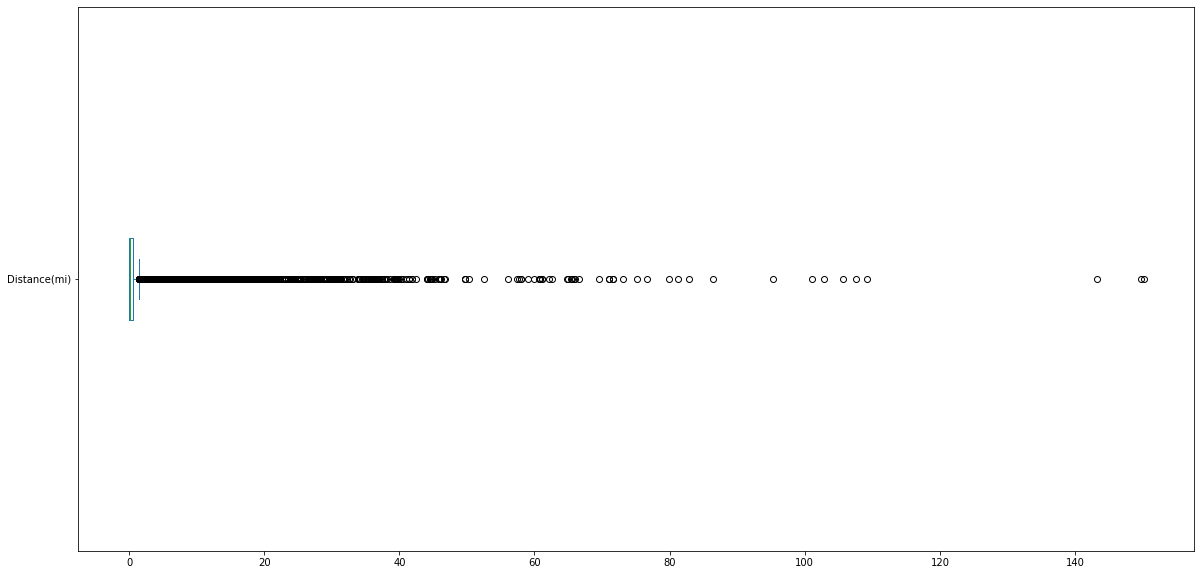

In [27]:
# let's have a peek at the box plot
train_df["Distance(mi)"].plot(kind='box', vert=False, figsize=(20,10))

* Lots of outliers for this one, but not necessarily impossible values I think
* We'll keep them for now and see if removing them, or try other stuff, is going to improve the model later

### -- Number

In [28]:
train_df["Number"]

0         17909.0
1             NaN
2             NaN
3             NaN
4         15683.0
           ...   
454814        1.0
454815        NaN
454816        NaN
454817    11993.0
454818        NaN
Name: Number, Length: 454819, dtype: float64

In [29]:
print(train_df["Number"].isna().sum())
print(val_df["Number"].isna().sum())
print(test_df["Number"].isna().sum())

313923
104815
104525


In [30]:
print(train_df["Number"].isna().sum() / train_df.shape[0] * 100)
print(val_df["Number"].isna().sum() / val_df.shape[0] * 100)
print(test_df["Number"].isna().sum() / test_df.shape[0] * 100)

69.02152284755034
69.13644578710606
68.94470571939291


* I'm guessing this column is the street number at the place of accident
* Very high percentage of nulls. But nothing much we can do as imputing is impossible in this case
* We can fill the nulls out with an empty string, and we can drop later in the modelling part to see how it affects

In [31]:
train_df["Number"] = train_df["Number"].fillna('')
val_df["Number"] = val_df["Number"].fillna('')
test_df["Number"] = test_df["Number"].fillna('')

In [32]:
# sanity check
print(train_df["Number"].isna().sum())
print(val_df["Number"].isna().sum())
print(test_df["Number"].isna().sum())

0
0
0


In [33]:
# cast to string as it makes the most sense
train_df["Number"] = train_df["Number"].astype("string")
val_df["Number"] = val_df["Number"].astype("string")
test_df["Number"] = test_df["Number"].astype("string")

### -- Street

In [34]:
train_df["Street"]

0           NE 6th Ave
1              US-51 S
2              CA-57 S
3              I-215 S
4          Highway 126
              ...     
454814      44th St SE
454815         CT-15 S
454816    Pomona Fwy W
454817      Merritt St
454818     Outerbelt N
Name: Street, Length: 454819, dtype: object

In [35]:
print(train_df["Street"].isna().sum())
print(val_df["Street"].isna().sum())
print(test_df["Street"].isna().sum())

0
0
0


In [36]:
# normalizing by lower everything
train_df["Street"] = train_df["Street"].apply(lambda x : x.lower().strip())
val_df["Street"] = val_df["Street"].apply(lambda x : x.lower().strip())
test_df["Street"] = test_df["Street"].apply(lambda x : x.lower().strip())

In [37]:
# just need to cast data type for this column
train_df["Street"] = train_df["Street"].astype("string")
val_df["Street"] = val_df["Street"].astype("string")
test_df["Street"] = test_df["Street"].astype("string")

### -- Side

In [38]:
train_df["Side"]

0         R
1         R
2         R
3         R
4         L
         ..
454814    L
454815    R
454816    R
454817    L
454818    R
Name: Side, Length: 454819, dtype: object

In [39]:
print(train_df["Side"].isna().sum())
print(val_df["Side"].isna().sum())
print(test_df["Side"].isna().sum())

0
0
0


In [40]:
# just need to cast data type for this column
# and one hot encode them later
train_df["Side"] = train_df["Side"].astype("string")
val_df["Side"] = val_df["Side"].astype("string")
test_df["Side"] = test_df["Side"].astype("string")

### -- City

In [41]:
train_df["City"].value_counts()

Los Angeles      11937
Miami            10956
Charlotte         6615
Houston           6170
Dallas            5910
                 ...  
Pauls Valley         1
Woodhaven            1
East Weymouth        1
De Mossville         1
Wibaux               1
Name: City, Length: 8887, dtype: int64

In [42]:
print(train_df["City"].isna().sum())
print(val_df["City"].isna().sum())
print(test_df["City"].isna().sum())

23
13
3


In [43]:
train_df[train_df["City"].isna() == True].head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
3373,4,1.484016e+09,1.484038e+09,40.843090,-84.802360,40.841207,-84.841024,2.025,11207.0,n 700 e,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3919,2,1.608619e+09,1.608667e+09,38.912285,-76.934168,38.908867,-76.937192,0.287,,eastern ave,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
63565,3,1.587169e+09,1.587171e+09,41.036740,-73.675490,41.036740,-73.675490,0.000,,king st,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
74853,2,1.606802e+09,1.606823e+09,38.912285,-76.934168,38.889809,-76.958621,2.035,,eastern ave,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
110945,2,1.592954e+09,1.592956e+09,41.036740,-73.675490,41.036740,-73.675490,0.000,,king st,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


* After some manual Googling on Google Maps with the latitude and longitude, I found that all these locations are in a border between 2 states, so the city is left null
* Now, we can try to impute the city by reverse geocoding the longitude and latitude and take the nearest city
* But other columns such as `Sunrise_Sunset`,`Civil_Twilight`, `Nautical_Twilight`, `Astronomical_Twilight` are also null and imputing them is going to take a lot more time unnecessarily
* And since the amount of nulls are extremely small, we can just fill the nulls with an empty string

In [44]:
train_df["City"] = train_df["City"].fillna('')
val_df["City"] = val_df["City"].fillna('')
test_df["City"] = test_df["City"].fillna('')

In [45]:
# sanity check
print(train_df["City"].isna().sum())
print(val_df["City"].isna().sum())
print(test_df["City"].isna().sum())

0
0
0


In [46]:
# normalizing by lower everything
train_df["City"] = train_df["City"].apply(lambda x : x.lower())
val_df["City"] = val_df["City"].apply(lambda x : x.lower())
test_df["City"] = test_df["City"].apply(lambda x : x.lower())

train_df["City"].value_counts()

los angeles        11937
miami              10956
charlotte           6615
houston             6170
dallas              5910
                   ...  
gap mills              1
petersham              1
sherwood forest        1
avella                 1
wibaux                 1
Name: City, Length: 8855, dtype: int64

In [47]:
# cast to string as it makes the most sense
train_df["City"] = train_df["City"].astype("string")
val_df["City"] = val_df["City"].astype("string")
test_df["City"] = test_df["City"].astype("string")

### -- County, State

In [48]:
print(train_df["County"].value_counts())
print(train_df["State"].value_counts())

Los Angeles       41629
Orange            15135
Miami-Dade        14317
San Bernardino     9138
San Diego          7943
                  ...  
Griggs                1
Trimble               1
Grenada               1
Ogemaw                1
Wibaux                1
Name: County, Length: 1535, dtype: int64
CA    134389
FL     46422
OR     26223
TX     22424
NY     18148
MN     15854
VA     15295
NC     15103
PA     12872
IL     12403
MD     10437
UT      9929
GA      9292
AZ      9105
NJ      8977
SC      8462
MI      8290
WA      6874
OH      6660
TN      6658
CO      5900
LA      5747
MO      5113
CT      4537
IN      3514
AL      2831
WI      2394
MA      1833
KY      1719
OK      1647
KS      1520
IA      1441
AR      1322
ID      1239
DC      1190
NH      1166
RI      1126
NV      1061
WV       997
MT       958
MS       853
ME       699
DE       699
NE       670
NM       444
ND       126
VT        96
WY        84
SD        76
Name: State, dtype: int64


In [49]:
print(train_df["County"].isna().sum())
print(val_df["County"].isna().sum())
print(test_df["County"].isna().sum())

0
0
0


In [50]:
print(train_df["State"].isna().sum())
print(val_df["State"].isna().sum())
print(test_df["State"].isna().sum())

0
0
0


In [51]:
# normalizing by lower everything
train_df["County"] = train_df["County"].apply(lambda x : x.lower())
val_df["County"] = val_df["County"].apply(lambda x : x.lower())
test_df["County"] = test_df["County"].apply(lambda x : x.lower())

print(train_df["County"].value_counts())

train_df["State"] = train_df["State"].apply(lambda x : x.lower())
val_df["State"] = val_df["State"].apply(lambda x : x.lower())
test_df["State"] = test_df["State"].apply(lambda x : x.lower())

train_df["State"].value_counts()

los angeles       41629
orange            15135
miami-dade        14317
san bernardino     9138
san diego          7943
                  ...  
jeff davis            1
cotton                1
concordia             1
republic              1
wibaux                1
Name: County, Length: 1522, dtype: int64


ca    134389
fl     46422
or     26223
tx     22424
ny     18148
mn     15854
va     15295
nc     15103
pa     12872
il     12403
md     10437
ut      9929
ga      9292
az      9105
nj      8977
sc      8462
mi      8290
wa      6874
oh      6660
tn      6658
co      5900
la      5747
mo      5113
ct      4537
in      3514
al      2831
wi      2394
ma      1833
ky      1719
ok      1647
ks      1520
ia      1441
ar      1322
id      1239
dc      1190
nh      1166
ri      1126
nv      1061
wv       997
mt       958
ms       853
me       699
de       699
ne       670
nm       444
nd       126
vt        96
wy        84
sd        76
Name: State, dtype: int64

In [52]:
# cast to string as it makes the most sense
train_df["County"] = train_df["County"].astype("string")
val_df["County"] = val_df["County"].astype("string")
test_df["County"] = test_df["County"].astype("string")

train_df["State"] = train_df["State"].astype("string")
val_df["State"] = val_df["State"].astype("string")
test_df["State"] = test_df["State"].astype("string")

### -- Zipcode

In [53]:
train_df["Zipcode"].value_counts()

91761         1119
91706          868
92407          827
92507          818
92324          675
              ... 
22911-8224       1
55355-4614       1
97447-9709       1
30274-4045       1
33037-2816       1
Name: Zipcode, Length: 83286, dtype: int64

In [54]:
print(train_df["Zipcode"].isna().sum())
print(val_df["Zipcode"].isna().sum())
print(test_df["Zipcode"].isna().sum())

277
99
82


* Same story as the `City` column but these places are generally in areas where there are no residence

In [55]:
train_df["Zipcode"] = train_df["Zipcode"].fillna('')
val_df["Zipcode"] = val_df["Zipcode"].fillna('')
test_df["Zipcode"] = test_df["Zipcode"].fillna('')

In [56]:
# sanity check
print(train_df["Zipcode"].isna().sum())
print(val_df["Zipcode"].isna().sum())
print(test_df["Zipcode"].isna().sum())

0
0
0


In [57]:
# cast to string as it makes the most sense
train_df["Zipcode"] = train_df["Zipcode"].astype("string")
val_df["Zipcode"] = val_df["Zipcode"].astype("string")
test_df["Zipcode"] = test_df["Zipcode"].astype("string")

### -- Country

In [58]:
train_df["Country"].value_counts()

US    454819
Name: Country, dtype: int64

* We're going to drop this column as it is pretty redundant because the dataset is in America only, so having a column with only 1 value is not going to help much

In [59]:
train_df = train_df.drop("Country", axis=1)
val_df = val_df.drop("Country", axis=1)
test_df = test_df.drop("Country", axis=1)

### -- Timezone

In [60]:
train_df["Timezone"].value_counts()

US/Eastern     176751
US/Pacific     168972
US/Central      79645
US/Mountain     28761
Name: Timezone, dtype: int64

In [61]:
print(train_df["Timezone"].isna().sum())
print(val_df["Timezone"].isna().sum())
print(test_df["Timezone"].isna().sum())

690
240
245


In [62]:
train_df[train_df["Timezone"].isna() == True].head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
860,2,1.544394e+09,1.544408e+09,44.160861,-121.358016,44.160845,-121.357964,0.003,64736.0,highway 20,...,False,False,False,False,False,False,Night,Night,Night,Night
970,2,1.606582e+09,1.606598e+09,30.519458,-87.143137,30.529237,-87.130063,1.031,,fl-8 e,...,False,False,False,False,False,False,Night,Night,Night,Night
1102,2,1.494047e+09,1.494068e+09,38.990740,-76.371660,38.983330,-76.340040,1.774,,william preston lane jr memorial brg,...,False,False,False,False,False,False,Day,Day,Day,Day
1408,2,1.541625e+09,1.541641e+09,44.875664,-67.403551,44.875660,-67.403550,0.000,595.0,cathance rd,...,False,False,False,False,False,False,Night,Night,Night,Night
2026,2,1.536138e+09,1.536153e+09,44.102670,-121.306120,44.101210,-121.305170,0.111,63397.0,highway 20,...,False,False,False,False,False,False,Day,Day,Day,Day


* Thought it might look like the same situtation as the `City` and `Zipcode` columns at first, this column is different because we can actually impute the nulls
* Taking the start latitude and longitude, we can look them to see what timezone they belong to
* Getting the timezone is being done in another helper function in a different python file as to not bloat this notebook

In [63]:
train_df["Timezone"] = \
    train_df[["Start_Lat", "Start_Lng", "Timezone"]].apply(
        lambda x : get_tz(x["Start_Lat"],x["Start_Lng"]) if pd.isna(x["Timezone"]) else x["Timezone"],
        axis=1
    )

val_df["Timezone"] = \
    val_df[["Start_Lat", "Start_Lng", "Timezone"]].apply(
        lambda x : get_tz(x["Start_Lat"],x["Start_Lng"]) if pd.isna(x["Timezone"]) else x["Timezone"],
        axis=1
    )

test_df["Timezone"] = \
    test_df[["Start_Lat", "Start_Lng", "Timezone"]].apply(
        lambda x : get_tz(x["Start_Lat"],x["Start_Lng"]) if pd.isna(x["Timezone"]) else x["Timezone"],
        axis=1
    )

In [64]:
# sanity check
print(train_df["Timezone"].value_counts())
print(train_df["Timezone"].isna().sum())
print(val_df["Timezone"].isna().sum())
print(test_df["Timezone"].isna().sum())

US/Eastern     176987
US/Pacific     169342
US/Central      79665
US/Mountain     28825
Name: Timezone, dtype: int64
0
0
0


In [65]:
# cast to string as it makes the most sense
train_df["Timezone"] = train_df["Timezone"].astype("string")
val_df["Timezone"] = val_df["Timezone"].astype("string")
test_df["Timezone"] = test_df["Timezone"].astype("string")

### -- Airport_Code

In [66]:
train_df["Airport_Code"].value_counts()

KCQT    9009
KEMT    5245
KFUL    4995
KSNA    4730
KCLT    4613
        ... 
KW43       1
KOXV       1
KGUN       1
KJWG       1
KIDP       1
Name: Airport_Code, Length: 1884, dtype: int64

In [67]:
print(train_df["Airport_Code"].isna().sum())
print(val_df["Airport_Code"].isna().sum())
print(test_df["Airport_Code"].isna().sum())

1294
428
431


* We can also try to impute here but it's too difficult and going to take up a lot of time
* So we'll just fill the nulls with an empty string

In [68]:
train_df["Airport_Code"] = train_df["Airport_Code"].fillna('')
val_df["Airport_Code"] = val_df["Airport_Code"].fillna('')
test_df["Airport_Code"] = test_df["Airport_Code"].fillna('')

In [69]:
# sanity check
print(train_df["Airport_Code"].isna().sum())
print(val_df["Airport_Code"].isna().sum())
print(test_df["Airport_Code"].isna().sum())

0
0
0


In [70]:
# normalizing by lower everything
train_df["Airport_Code"] = train_df["Airport_Code"].apply(lambda x : x.lower())
val_df["Airport_Code"] = val_df["Airport_Code"].apply(lambda x : x.lower())
test_df["Airport_Code"] = test_df["Airport_Code"].apply(lambda x : x.lower())

train_df["Airport_Code"].value_counts()

kcqt    9009
kemt    5245
kful    4995
ksna    4730
kclt    4613
        ... 
kckm       1
kbwp       1
kbie       1
krtn       1
kidp       1
Name: Airport_Code, Length: 1885, dtype: int64

In [71]:
# cast to string as it makes the most sense
train_df["Airport_Code"] = train_df["Airport_Code"].astype("string")
val_df["Airport_Code"] = val_df["Airport_Code"].astype("string")
test_df["Airport_Code"] = test_df["Airport_Code"].astype("string")

### -- Weather_Timestamp

In [72]:
train_df['Weather_Timestamp']

0         2020-12-17 13:53:00
1         2017-04-27 14:20:00
2         2020-12-29 00:53:00
3         2019-11-12 15:54:00
4         2020-01-10 19:32:00
                 ...         
454814    2020-05-20 16:53:00
454815                    NaN
454816    2017-05-25 05:53:00
454817    2017-01-19 17:53:00
454818    2017-10-05 15:45:00
Name: Weather_Timestamp, Length: 454819, dtype: object

In [73]:
print(train_df["Weather_Timestamp"].isna().sum())
print(val_df["Weather_Timestamp"].isna().sum())
print(test_df["Weather_Timestamp"].isna().sum())

9104
3050
3013


In [74]:
with warnings.catch_warnings(record=True):
    # let's see if there are any microsecond parts like the other timestamp columns
    print(train_df['Weather_Timestamp'].str.contains(regex_str).value_counts())
    print(val_df['Weather_Timestamp'].str.contains(regex_str).value_counts())
    print(test_df['Weather_Timestamp'].str.contains(regex_str).value_counts())

False    445715
Name: Weather_Timestamp, dtype: int64
False    148556
Name: Weather_Timestamp, dtype: int64
False    148594
Name: Weather_Timestamp, dtype: int64


* No microseconds part, just nulls, so we don't need to do the truncation
* We will convert the timestamp to unix timestamp like `Start_Time` and `End_Time`
* If timestamp is null, we will impute by getting the average of `Start_Time` and `End_Time`

In [75]:
train_df['Weather_Timestamp'] = \
    train_df[['Start_Time','End_Time','Weather_Timestamp']].apply(
        lambda t : datetime_obj.strptime(t['Weather_Timestamp'], format_str).timestamp() \
            if not pd.isna(t['Weather_Timestamp']) \
            else round(t['Start_Time'] + t['End_Time'] / 2, ndigits=1),
        axis=1
    )

val_df['Weather_Timestamp'] = \
    val_df[['Start_Time','End_Time','Weather_Timestamp']].apply(
        lambda t : datetime_obj.strptime(t['Weather_Timestamp'], format_str).timestamp() \
            if not pd.isna(t['Weather_Timestamp']) \
            else round(t['Start_Time'] + t['End_Time'] / 2, ndigits=1),
        axis=1
    )

test_df['Weather_Timestamp'] = \
    test_df[['Start_Time','End_Time','Weather_Timestamp']].apply(
        lambda t : datetime_obj.strptime(t['Weather_Timestamp'], format_str).timestamp() \
            if not pd.isna(t['Weather_Timestamp']) \
            else round(t['Start_Time'] + t['End_Time'] / 2, ndigits=1),
        axis=1
    )

In [76]:
# sanity check
print(train_df["Weather_Timestamp"].isna().sum())
print(val_df["Weather_Timestamp"].isna().sum())
print(test_df["Weather_Timestamp"].isna().sum())

0
0
0


### -- Temperature(F)

In [77]:
train_df['Temperature(F)']

0         81.0
1         42.1
2         47.0
3         56.0
4         47.0
          ... 
454814    71.0
454815     NaN
454816    57.0
454817    53.1
454818    68.0
Name: Temperature(F), Length: 454819, dtype: float64

In [78]:
print(train_df['Temperature(F)'].isna().sum())
print(val_df['Temperature(F)'].isna().sum())
print(test_df['Temperature(F)'].isna().sum())

12910
4312
4345


<AxesSubplot:>

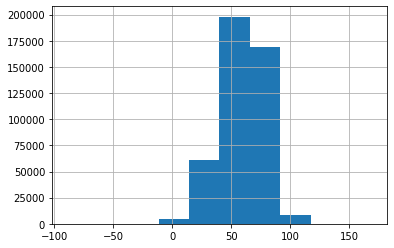

In [79]:
# check the distribution
train_df["Temperature(F)"].hist()

* For this column, we'll try to impute the nulls with the average temperature

In [80]:
train_df["Temperature(F)"] = train_df["Temperature(F)"].fillna(round(train_df["Temperature(F)"].mean(), ndigits=1))
val_df["Temperature(F)"] = val_df["Temperature(F)"].fillna(round(val_df["Temperature(F)"].mean(), ndigits=1))
test_df["Temperature(F)"] = test_df["Temperature(F)"].fillna(round(test_df["Temperature(F)"].mean(), ndigits=1))

In [81]:
# sanity check
print(train_df['Temperature(F)'].isna().sum())
print(val_df['Temperature(F)'].isna().sum())
print(test_df['Temperature(F)'].isna().sum())

0
0
0


### -- Wind_Chill(F)

In [82]:
train_df['Wind_Chill(F)']

0         81.0
1         37.1
2         44.0
3         56.0
4         41.0
          ... 
454814    71.0
454815     NaN
454816     NaN
454817     NaN
454818     NaN
Name: Wind_Chill(F), Length: 454819, dtype: float64

In [83]:
print(train_df['Wind_Chill(F)'].isna().sum())
print(val_df['Wind_Chill(F)'].isna().sum())
print(test_df['Wind_Chill(F)'].isna().sum())

134958
45147
44908


In [84]:
print(train_df['Wind_Chill(F)'].isna().sum() / train_df.shape[0] * 100)
print(val_df['Wind_Chill(F)'].isna().sum() / val_df.shape[0] * 100)
print(test_df['Wind_Chill(F)'].isna().sum() / test_df.shape[0] * 100)

29.672902847066634
29.779164413017956
29.62132355366177


<AxesSubplot:>

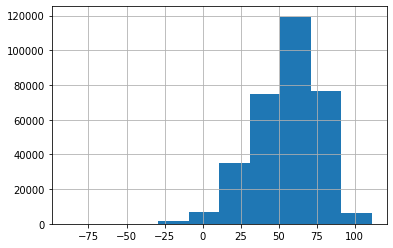

In [85]:
# check the distribution
train_df["Wind_Chill(F)"].hist()

* Around 30% of nulls for all datasets, which is very large
* I'm thinking just impute the nulls with the average as well, and we'll see later if dropping them improves the model instead

In [86]:
train_df["Wind_Chill(F)"] = train_df["Wind_Chill(F)"].fillna(round(train_df["Wind_Chill(F)"].mean(), ndigits=1))
val_df["Wind_Chill(F)"] = val_df["Wind_Chill(F)"].fillna(round(val_df["Wind_Chill(F)"].mean(), ndigits=1))
test_df["Wind_Chill(F)"] = test_df["Wind_Chill(F)"].fillna(round(test_df["Wind_Chill(F)"].mean(), ndigits=1))

In [87]:
# sanity check
print(train_df['Wind_Chill(F)'].isna().sum())
print(val_df['Wind_Chill(F)'].isna().sum())
print(test_df['Wind_Chill(F)'].isna().sum())

0
0
0


### -- Humidity(%)

In [88]:
train_df['Humidity(%)']

0         74.0
1         76.0
2         74.0
3         29.0
4         83.0
          ... 
454814    41.0
454815     NaN
454816    87.0
454817    77.0
454818    94.0
Name: Humidity(%), Length: 454819, dtype: float64

In [89]:
print(train_df['Humidity(%)'].isna().sum())
print(val_df['Humidity(%)'].isna().sum())
print(test_df['Humidity(%)'].isna().sum())

13670
4545
4584


<AxesSubplot:>

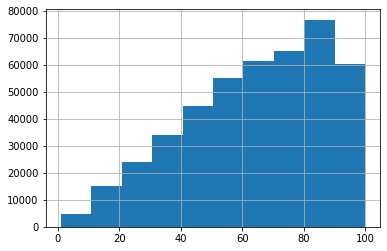

In [90]:
# check the distribution
train_df["Humidity(%)"].hist()

In [91]:
print(train_df["Humidity(%)"].mean())
print(train_df["Humidity(%)"].mode()[0])

64.65139442682631
93.0


* For this one, I think imputing with the mode makes more sense than the average because it is more common for humidity to be around 90-100%
* Again, for these imputations, we can try to see if dropping them later helps with the model

In [92]:
train_df["Humidity(%)"] = train_df["Humidity(%)"].fillna(train_df["Humidity(%)"].mode()[0])
val_df["Humidity(%)"] = val_df["Humidity(%)"].fillna(val_df["Humidity(%)"].mode()[0])
test_df["Humidity(%)"] = test_df["Humidity(%)"].fillna(test_df["Humidity(%)"].mode()[0])

In [93]:
# sanity check
print(train_df['Humidity(%)'].isna().sum())
print(val_df['Humidity(%)'].isna().sum())
print(test_df['Humidity(%)'].isna().sum())

0
0
0


### -- Pressure(in)

In [94]:
train_df['Pressure(in)']

0         30.01
1         29.57
2         29.86
3         25.83
4         29.52
          ...  
454814    29.18
454815      NaN
454816    29.81
454817    29.90
454818    30.18
Name: Pressure(in), Length: 454819, dtype: float64

In [95]:
print(train_df['Pressure(in)'].isna().sum())
print(val_df['Pressure(in)'].isna().sum())
print(test_df['Pressure(in)'].isna().sum())

10865
3641
3638


<AxesSubplot:>

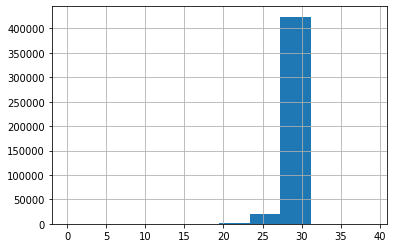

In [96]:
# check the distribution
train_df["Pressure(in)"].hist()

* For this one, it doesn't matter if we'll impute with mode or mean because they're pretty much the same

In [97]:
train_df["Pressure(in)"] = train_df["Pressure(in)"].fillna(train_df["Pressure(in)"].mean())
val_df["Pressure(in)"] = val_df["Pressure(in)"].fillna(val_df["Pressure(in)"].mean())
test_df["Pressure(in)"] = test_df["Pressure(in)"].fillna(test_df["Pressure(in)"].mean())

In [98]:
# sanity check
print(train_df['Pressure(in)'].isna().sum())
print(val_df['Pressure(in)'].isna().sum())
print(test_df['Pressure(in)'].isna().sum())

0
0
0


### -- Visibility(mi)

In [99]:
train_df['Visibility(mi)']

0         10.0
1         10.0
2         10.0
3         10.0
4          6.0
          ... 
454814    10.0
454815     NaN
454816    10.0
454817    10.0
454818     7.0
Name: Visibility(mi), Length: 454819, dtype: float64

In [100]:
print(train_df['Visibility(mi)'].isna().sum())
print(val_df['Visibility(mi)'].isna().sum())
print(test_df['Visibility(mi)'].isna().sum())

13276
4467
4456


<AxesSubplot:>

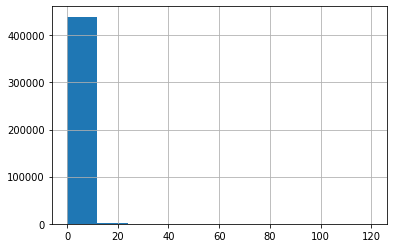

In [101]:
# check the distribution
train_df["Visibility(mi)"].hist()

In [102]:
# impute with mode for this one
train_df["Visibility(mi)"] = train_df["Visibility(mi)"].fillna(train_df["Visibility(mi)"].mode()[0])
val_df["Visibility(mi)"] = val_df["Visibility(mi)"].fillna(val_df["Visibility(mi)"].mode()[0])
test_df["Visibility(mi)"] = test_df["Visibility(mi)"].fillna(test_df["Visibility(mi)"].mode()[0])

In [103]:
# sanity check
print(train_df['Visibility(mi)'].isna().sum())
print(val_df['Visibility(mi)'].isna().sum())
print(test_df['Visibility(mi)'].isna().sum())

0
0
0


### -- Wind_Direction

In [104]:
train_df['Wind_Direction'].value_counts()

CALM        60709
Calm        23803
WNW         23373
NW          22786
W           21616
SSW         20848
WSW         20645
NNW         20450
S           20228
SW          19645
SSE         19477
SE          16559
N           16166
E           15612
ESE         15468
ENE         15163
NE          14612
NNE         13982
West        12182
South       12109
VAR         12069
North       10634
East         7214
Variable     6899
Name: Wind_Direction, dtype: int64

In [105]:
print(train_df['Wind_Direction'].isna().sum())
print(val_df['Wind_Direction'].isna().sum())
print(test_df['Wind_Direction'].isna().sum())

12570
4203
4195


In [106]:
# impute with "calm" as it is the mode
train_df["Wind_Direction"] = train_df["Wind_Direction"].fillna("calm")
val_df["Wind_Direction"] = val_df["Wind_Direction"].fillna("calm")
test_df["Wind_Direction"] = test_df["Wind_Direction"].fillna("calm")

In [107]:
wind_dir = {
    'west': 'w',
    'south': 's',
    'north': 'n',
    'east': 'e',
    'variable': 'var'
}

# lower the strings
train_df['Wind_Direction'] = train_df['Wind_Direction'].apply(lambda x : x.lower())
val_df['Wind_Direction'] = val_df['Wind_Direction'].apply(lambda x : x.lower())
test_df['Wind_Direction'] = test_df['Wind_Direction'].apply(lambda x : x.lower())

# normalize the categories
train_df['Wind_Direction'] = train_df['Wind_Direction'].replace(wind_dir)
val_df['Wind_Direction'] = val_df['Wind_Direction'].replace(wind_dir)
test_df['Wind_Direction'] = test_df['Wind_Direction'].replace(wind_dir)

In [108]:
train_df['Wind_Direction'].value_counts()

calm    97082
w       33798
s       32337
n       26800
wnw     23373
e       22826
nw      22786
ssw     20848
wsw     20645
nnw     20450
sw      19645
sse     19477
var     18968
se      16559
ese     15468
ene     15163
ne      14612
nne     13982
Name: Wind_Direction, dtype: int64

In [109]:
# sanity check
print(train_df['Wind_Direction'].isna().sum())
print(val_df['Wind_Direction'].isna().sum())
print(test_df['Wind_Direction'].isna().sum())

0
0
0


In [110]:
# cast to string as it makes the most sense
train_df["Wind_Direction"] = train_df["Wind_Direction"].astype("string")
val_df["Wind_Direction"] = val_df["Wind_Direction"].astype("string")
test_df["Wind_Direction"] = test_df["Wind_Direction"].astype("string")

### -- Wind_Speed(mph)

In [111]:
train_df['Wind_Speed(mph)'].describe()

count    416103.000000
mean          7.630367
std           5.498013
min           0.000000
25%           4.600000
50%           7.000000
75%          10.400000
max         518.000000
Name: Wind_Speed(mph), dtype: float64

In [112]:
# max in the 3 digits but mean is only 1 digit, let's check further
train_df['Wind_Speed(mph)'].sort_values(ascending=False)

241158    518.0
114534    232.0
143844    161.0
147076    142.0
77214     141.5
          ...  
454775      NaN
454799      NaN
454801      NaN
454806      NaN
454815      NaN
Name: Wind_Speed(mph), Length: 454819, dtype: float64

In [113]:
train_df['Wind_Speed(mph)'].value_counts().sort_index(ascending=False)

518.0        1
232.0        1
161.0        1
142.0        1
141.5        1
         ...  
2.3         82
2.0         24
1.2         40
1.0         14
0.0      60710
Name: Wind_Speed(mph), Length: 95, dtype: int64

<AxesSubplot:>

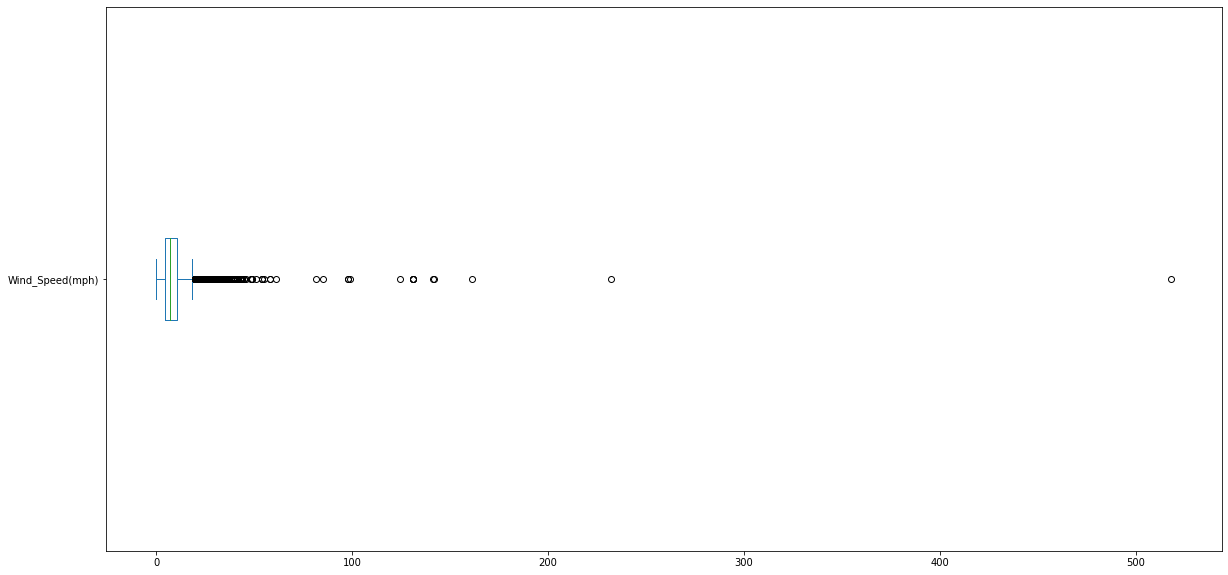

In [114]:
# let's take a peek at the box plot for this
train_df['Wind_Speed(mph)'].plot(kind='box', vert=False, figsize=(20,10))

* According to [here](https://en.wikipedia.org/wiki/Wind_speed#Highest_speed), the highest wind speed ever recorded was 253mph, so the 518mph is an impossible value
* The Wikipedia also stated the 2nd highest wind speed recorded was 231mph back in 1934, so the 232mph is also an impossible value
* The 3rd highest value in our data is within the realm of possibility at 161pmh. So we will cap the outliers to that speed instead

In [115]:
train_df['Wind_Speed(mph)'] = train_df['Wind_Speed(mph)'].clip(0, 161)

train_df['Wind_Speed(mph)'].sort_values(ascending=False)

241158    161.0
143844    161.0
114534    161.0
147076    142.0
77214     141.5
          ...  
454775      NaN
454799      NaN
454801      NaN
454806      NaN
454815      NaN
Name: Wind_Speed(mph), Length: 454819, dtype: float64

<AxesSubplot:>

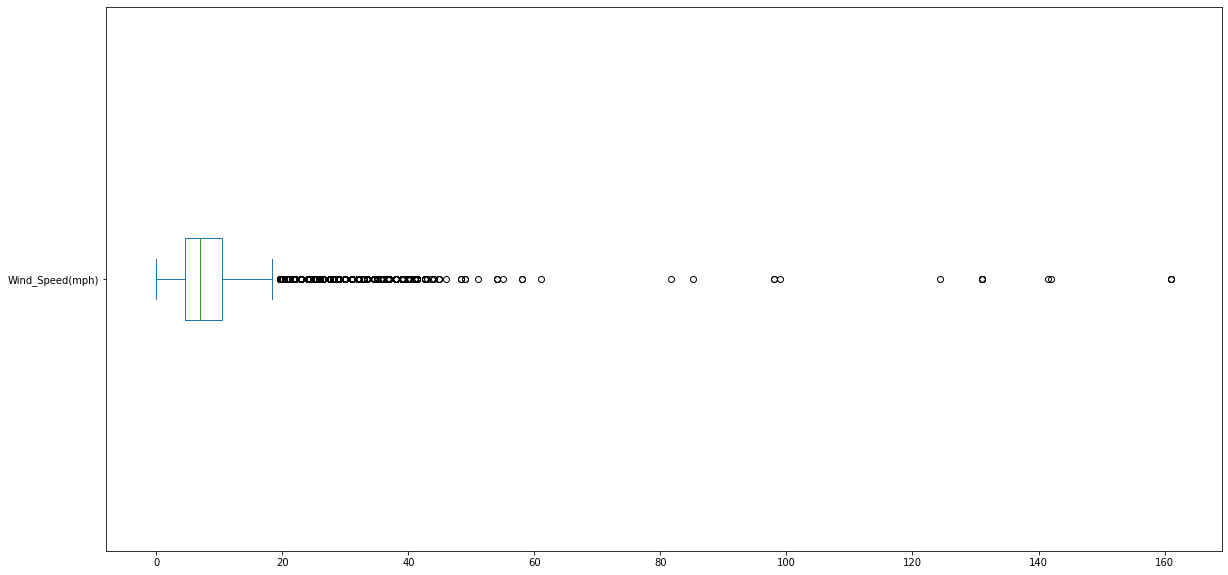

In [116]:
# much more reasonable box plot now
train_df['Wind_Speed(mph)'].plot(kind='box', vert=False, figsize=(20,10))

<AxesSubplot:>

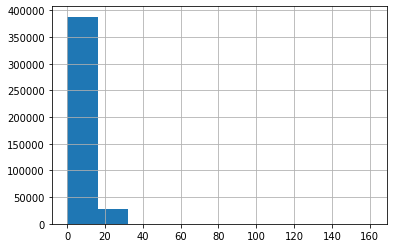

In [117]:
train_df['Wind_Speed(mph)'].hist()

In [118]:
print(train_df['Wind_Speed(mph)'].isna().sum())
print(val_df['Wind_Speed(mph)'].isna().sum())
print(test_df['Wind_Speed(mph)'].isna().sum())

38716
12977
12895


In [119]:
# impute with mean for this one
train_df["Wind_Speed(mph)"] = train_df["Wind_Speed(mph)"].fillna(train_df["Wind_Speed(mph)"].mean())
val_df["Wind_Speed(mph)"] = val_df["Wind_Speed(mph)"].fillna(val_df["Wind_Speed(mph)"].mean())
test_df["Wind_Speed(mph)"] = test_df["Wind_Speed(mph)"].fillna(test_df["Wind_Speed(mph)"].mean())

In [120]:
# sanity check
print(train_df['Wind_Speed(mph)'].isna().sum())
print(val_df['Wind_Speed(mph)'].isna().sum())
print(test_df['Wind_Speed(mph)'].isna().sum())

0
0
0


### -- Precipitation(in)

In [121]:
train_df['Precipitation(in)'].describe()

count    301402.000000
mean          0.008520
std           0.125945
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: Precipitation(in), dtype: float64

In [122]:
train_df['Precipitation(in)'].value_counts().sort_index(ascending=False)

24.00         1
10.05         1
10.00         5
9.99         20
9.98          3
          ...  
0.04       2271
0.03       2914
0.02       4314
0.01       8647
0.00     270748
Name: Precipitation(in), Length: 136, dtype: int64

<AxesSubplot:>

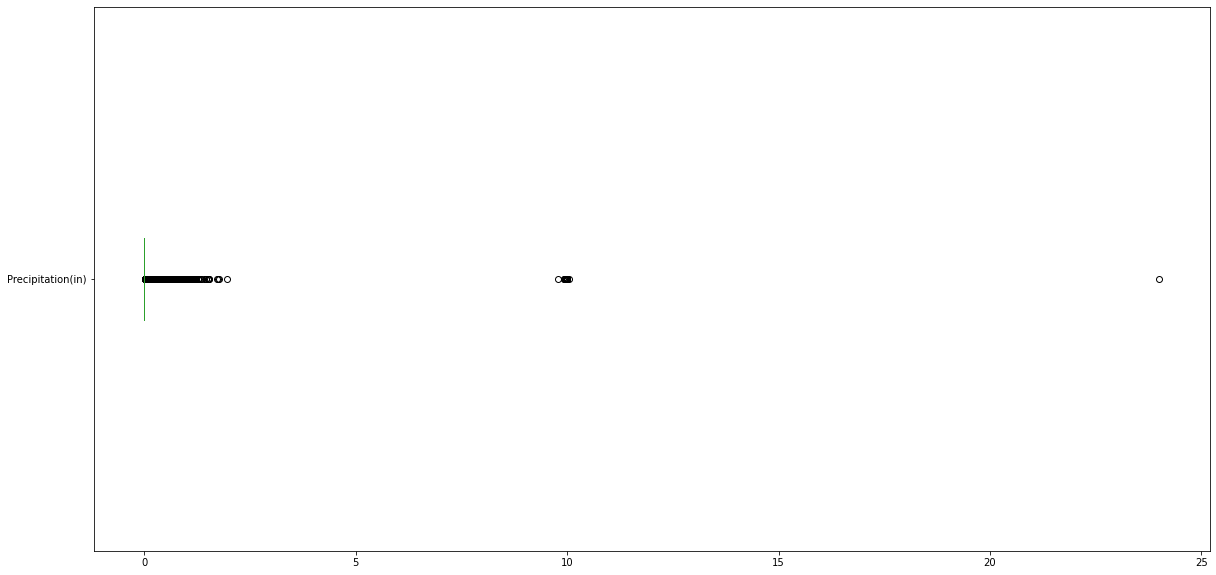

In [123]:
train_df['Precipitation(in)'].plot(kind='box', vert=False, figsize=(20,10))

* For this one, I think it is reasonable to just clip the 24 inches outlier to 10.05 inches and still keep the 9-10 inches bunch

In [124]:
# capping the 24inches outlier to 10.05inches
train_df['Precipitation(in)'] = train_df['Precipitation(in)'].clip(0, 10.05)

train_df['Precipitation(in)'].sort_values(ascending=False)

9750      10.05
336713    10.05
199861    10.00
70396     10.00
415234    10.00
          ...  
454809      NaN
454815      NaN
454816      NaN
454817      NaN
454818      NaN
Name: Precipitation(in), Length: 454819, dtype: float64

In [125]:
print(train_df['Precipitation(in)'].isna().sum())
print(val_df['Precipitation(in)'].isna().sum())
print(test_df['Precipitation(in)'].isna().sum())

153417
51332
50853


In [126]:
print(train_df['Precipitation(in)'].isna().sum() / train_df.shape[0] * 100)
print(val_df['Precipitation(in)'].isna().sum() / val_df.shape[0] * 100)
print(test_df['Precipitation(in)'].isna().sum() / test_df.shape[0] * 100)

33.73144041915575
33.85881825257576
33.54264644772339


In [127]:
# very high percentage of nulls, but we can also drop them later if it doesn't work out
# impute with mean for this one
train_df["Precipitation(in)"] = train_df["Precipitation(in)"].fillna(train_df["Precipitation(in)"].mean())
val_df["Precipitation(in)"] = val_df["Precipitation(in)"].fillna(val_df["Precipitation(in)"].mean())
test_df["Precipitation(in)"] = test_df["Precipitation(in)"].fillna(test_df["Precipitation(in)"].mean())

In [128]:
print(train_df['Precipitation(in)'].isna().sum())
print(val_df['Precipitation(in)'].isna().sum())
print(test_df['Precipitation(in)'].isna().sum())

0
0
0


### -- Weather_Condition

In [129]:
train_df["Weather_Condition"].value_counts()

Fair                            139626
Mostly Cloudy                    57682
Clear                            54290
Cloudy                           48248
Partly Cloudy                    40045
                                 ...  
Heavy Ice Pellets                    1
Funnel Cloud                         1
Thunder / Wintry Mix / Windy         1
Tornado                              1
Light Snow with Thunder              1
Name: Weather_Condition, Length: 102, dtype: int64

In [130]:
print(train_df['Weather_Condition'].isna().sum())
print(val_df['Weather_Condition'].isna().sum())
print(test_df['Weather_Condition'].isna().sum())

13196
4443
4433


In [131]:
# impute with "fair" as it is the mode
train_df["Weather_Condition"] = train_df["Weather_Condition"].fillna("fair")
val_df["Weather_Condition"] = val_df["Weather_Condition"].fillna("fair")
test_df["Weather_Condition"] = test_df["Weather_Condition"].fillna("fair")

In [132]:
# sanity check
print(train_df['Weather_Condition'].isna().sum())
print(val_df['Weather_Condition'].isna().sum())
print(test_df['Weather_Condition'].isna().sum())

0
0
0


In [133]:
# lower the strings
train_df['Weather_Condition'] = train_df['Weather_Condition'].apply(lambda x : x.lower())
val_df['Weather_Condition'] = val_df['Weather_Condition'].apply(lambda x : x.lower())
test_df['Weather_Condition'] = test_df['Weather_Condition'].apply(lambda x : x.lower())

train_df["Weather_Condition"].value_counts()

fair                            152822
mostly cloudy                    57682
clear                            54290
cloudy                           48248
partly cloudy                    40045
                                 ...  
heavy ice pellets                    1
funnel cloud                         1
thunder / wintry mix / windy         1
tornado                              1
light snow with thunder              1
Name: Weather_Condition, Length: 102, dtype: int64

* Splitting up the conditions would make sense here, but the data seems to be a categorical value, so splitting them up might be misinterpretting the data

In [134]:
# cast to string as it makes the most sense
train_df["Weather_Condition"] = train_df["Weather_Condition"].astype("string")
val_df["Weather_Condition"] = val_df["Weather_Condition"].astype("string")
test_df["Weather_Condition"] = test_df["Weather_Condition"].astype("string")

### -- Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop

In [135]:
train_df[[
    'Amenity',
    'Bump',
    'Crossing',
    'Give_Way',
    'Junction',
    'No_Exit',
    'Railway',
    'Roundabout',
    'Station',
    'Stop',
    'Traffic_Calming',
    'Traffic_Signal',
    'Turning_Loop'
]].isna().sum()

Amenity            0
Bump               0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

In [136]:
val_df[[
    'Amenity',
    'Bump',
    'Crossing',
    'Give_Way',
    'Junction',
    'No_Exit',
    'Railway',
    'Roundabout',
    'Station',
    'Stop',
    'Traffic_Calming',
    'Traffic_Signal',
    'Turning_Loop'
]].isna().sum()

Amenity            0
Bump               0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

In [137]:
test_df[[
    'Amenity',
    'Bump',
    'Crossing',
    'Give_Way',
    'Junction',
    'No_Exit',
    'Railway',
    'Roundabout',
    'Station',
    'Stop',
    'Traffic_Calming',
    'Traffic_Signal',
    'Turning_Loop'
]].isna().sum()

Amenity            0
Bump               0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

* These 13 columns are in perfect condition with no nulls and correct data type
* No further actions required for this bunch

### -- Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight

In [138]:
print(train_df["Sunrise_Sunset"].value_counts())
print(train_df["Civil_Twilight"].value_counts())
print(train_df["Nautical_Twilight"].value_counts())
print(train_df["Astronomical_Twilight"].value_counts())

Day      272967
Night    181829
Name: Sunrise_Sunset, dtype: int64
Day      290813
Night    163983
Name: Civil_Twilight, dtype: int64
Day      310554
Night    144242
Name: Nautical_Twilight, dtype: int64
Day      327141
Night    127655
Name: Astronomical_Twilight, dtype: int64


In [139]:
print(train_df["Sunrise_Sunset"].isna().sum())
print(train_df["Civil_Twilight"].isna().sum())
print(train_df["Nautical_Twilight"].isna().sum())
print(train_df["Astronomical_Twilight"].isna().sum())

23
23
23
23


* All of these nulls correlate with the nulls in the `City` column
* So, doing the same thing as the `City` column, we will fill the nulls out with an empty string

In [140]:
train_df["Sunrise_Sunset"] = train_df["Sunrise_Sunset"].fillna("")
val_df["Sunrise_Sunset"] = val_df["Sunrise_Sunset"].fillna("")
test_df["Sunrise_Sunset"] = test_df["Sunrise_Sunset"].fillna("")

train_df["Civil_Twilight"] = train_df["Civil_Twilight"].fillna("")
val_df["Civil_Twilight"] = val_df["Civil_Twilight"].fillna("")
test_df["Civil_Twilight"] = test_df["Civil_Twilight"].fillna("")

train_df["Nautical_Twilight"] = train_df["Nautical_Twilight"].fillna("")
val_df["Nautical_Twilight"] = val_df["Nautical_Twilight"].fillna("")
test_df["Nautical_Twilight"] = test_df["Nautical_Twilight"].fillna("")

train_df["Astronomical_Twilight"] = train_df["Astronomical_Twilight"].fillna("")
val_df["Astronomical_Twilight"] = val_df["Astronomical_Twilight"].fillna("")
test_df["Astronomical_Twilight"] = test_df["Astronomical_Twilight"].fillna("")

In [141]:
# cast to string as it makes the most sense

train_df["Sunrise_Sunset"] = train_df["Sunrise_Sunset"].astype("string")
val_df["Sunrise_Sunset"] = val_df["Sunrise_Sunset"].astype("string")
test_df["Sunrise_Sunset"] = test_df["Sunrise_Sunset"].astype("string")

train_df["Civil_Twilight"] = train_df["Civil_Twilight"].astype("string")
val_df["Civil_Twilight"] = val_df["Civil_Twilight"].astype("string")
test_df["Civil_Twilight"] = test_df["Civil_Twilight"].astype("string")

train_df["Nautical_Twilight"] = train_df["Nautical_Twilight"].astype("string")
val_df["Nautical_Twilight"] = val_df["Nautical_Twilight"].astype("string")
test_df["Nautical_Twilight"] = test_df["Nautical_Twilight"].astype("string")

train_df["Astronomical_Twilight"] = train_df["Astronomical_Twilight"].astype("string")
val_df["Astronomical_Twilight"] = val_df["Astronomical_Twilight"].astype("string")
test_df["Astronomical_Twilight"] = test_df["Astronomical_Twilight"].astype("string")

In [142]:
# sum of sums of nulls
print(train_df.isna().sum().sum())
print(val_df.isna().sum().sum())
print(test_df.isna().sum().sum())

0
0
0


# Task 1.2: Data Exploration

### Graph 1: Distribution of accidents per hour per day in a week
* Column used: `Start_Time`

In [143]:
# convert the timestamp back to a datetime object
graph1_df = train_df["Start_Time"].apply(lambda x : dt.datetime.fromtimestamp(x)).to_frame('Start_Time')

# get the weekday and hour from each timestamp
graph1_df["weekday"] = graph1_df["Start_Time"].apply(lambda x : x.weekday())
graph1_df["hour"] = graph1_df["Start_Time"].apply(lambda x : x.time().hour)
graph1_df = graph1_df.drop("Start_Time", axis=1)

# get value count of each weekday + hour combo
graph1_df = graph1_df.value_counts().reset_index(name='count')

graph1_df

,weekday,hour,count
0,4,16,5981
1,3,17,5964
2,4,17,5895
3,2,17,5820
4,3,16,5760
...,...,...,...
163,4,4,1192
164,5,5,1177
165,1,4,1152
166,6,8,1139


<AxesSubplot:xlabel='Day of the week', ylabel='Hour of the day'>

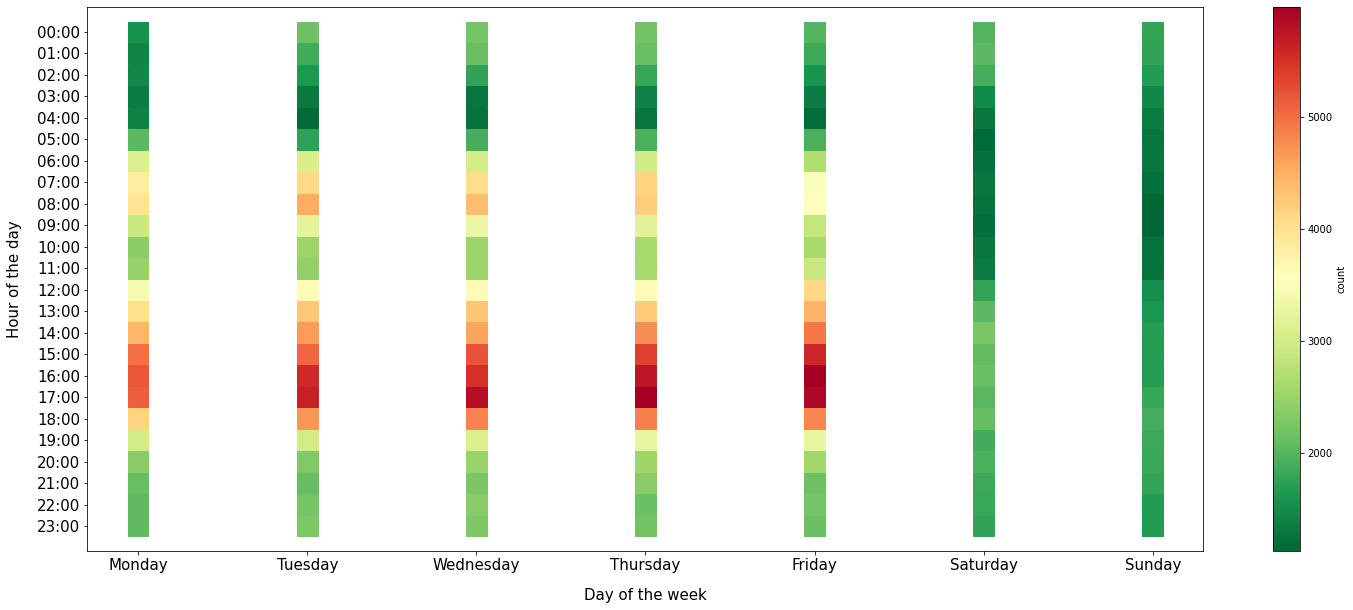

In [144]:
# green to yellow to red colormap, fits best for this data
new_cm = cm.get_cmap('RdYlGn').reversed()

# using a scatter plot for this graph
ax = graph1_df.plot.scatter(
        x='weekday',
        y='hour',
        c='count',
        s=420,
        colormap=new_cm,
        figsize=(25,10),
        sharex=False,
        fontsize=15,
        marker='s'
    )
# labeling stuff
ax.invert_yaxis()
ax.set_xlabel('Day of the week', fontsize=15, labelpad=15)
ax.set_ylabel('Hour of the day', fontsize=15, labelpad=15)
ax.set_xticks(range(7))
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set_yticks(range(24))
ax.set_yticklabels([f"{i:02}:00" for i in range(24)])
ax

* This graph is made by extracting the weekday and the hour from the timestamps in the `Start_Time` column. And then we can get the value counts for each combination of hour and weekday. From there, we can plot the values over a scatter plot, and see what is the distribution of the accidents per hour per day in a week.
* From this graph, we can see that accidents happen mostly around the afternoon hours of a workweek. And the lowest rates are around the weekends and 3-4 AM for the workweek. This looks to be very realistic as the rush hours are usually when people leave their house to go to work (7-9AM timeframe) and when people come home from work (3-5PM). And with the large amount of vehicles on the road and people wanting to go to work or home quickly, accidents are definitely more likely to happen. Although, I am surprised by the extremely low rate during the weekends, when people are most likely to go out and have fun, so I'm guessing people don't leave their house that much for the weekends in the US.

### Graph 2: Distribution of accidents geographically
* Column used: `Start_Lat`, `Start_Lng`

In [145]:
# create a GeoDataFrame from the existing coordinates
geometry = [Point(xy) for xy in zip(train_df["Start_Lng"], train_df["Start_Lat"])]
gdf = GeoDataFrame(train_df, geometry=geometry)

In [146]:
# get the map of USA 
states = gpd.read_file('./geo_data/usa-states-census-2014.shp')
# set the dataframe to using latitude and longitude coordinates
states = states.to_crs("EPSG:4326")

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

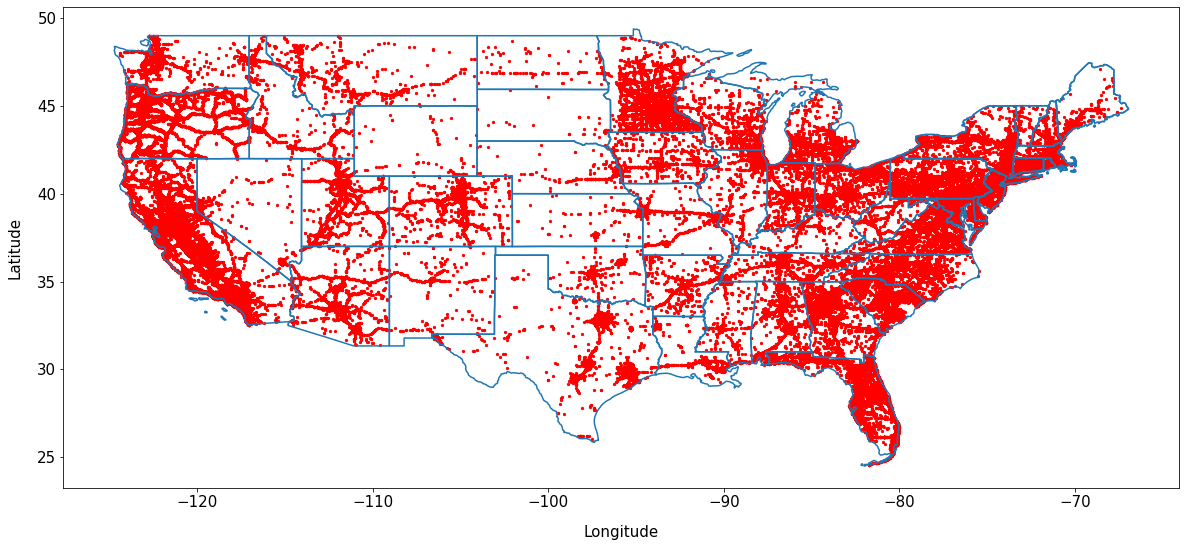

In [147]:
ax = gdf.plot(ax=states.boundary.plot(figsize=(20,15)), marker="o", color="red", markersize=5)
ax.set_xlabel("Longitude", fontsize=15, labelpad=15)
ax.set_ylabel("Latitude", fontsize=15, labelpad=15)
ax.tick_params(labelsize=15)
ax

* This graph is made with the `Start_Lng` and `Start_Lat` column, and with the help of the `geopandas` and `Shapely` libraries. The graph takes in the Latitude and Longitude coordinates of the dataset and plot it against a map of the Contiguous US to see the precise position where the accidents happened.

Reference map:
![Reference image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Map_of_USA_showing_state_names.png/640px-Map_of_USA_showing_state_names.png)
* From this graph, we can see that most accidents happened in the west and east coast of USA. This makes a lot of sense since this is where the highest population of the country concentrates. Also, there are also a high concentration of accidents in the Midwest and the South. In the Midwest, Minnesota, Wisconsin, Michigan, Indiana and Ohio are some states that have a very high concentration of accidents as well. In the South, we can see very clearly the high concentration of accidents in big cities of states like Dallas, Austin, San Antonio and Houston in Texas, Oklahoma City in Oklahoma, etc. This supports the hypothesis that accidents happen at a higher rate big cities of states rather than in the more sparse country part. Left of Minnesota, we can see a very clear line of accidents running along North Dakota, and it runs a bit back to Montana as well. I believe this line is the [Interstate 94](https://en.wikipedia.org/wiki/Interstate_94), an east-west highway connecting multiple states. This supports the hypothesis that accidents happened a lot along long highways, and aside from Interstate 94, we can make out some other lines in the map as well, and I believe they are also important and big highways connecting the many states.


*Credits:*
* *https://datascientyst.com/plot-latitude-longitude-pandas-dataframe-python/*
* *https://jcutrer.com/python/learn-geopandas-plotting-usmaps*

### Graph 3: Effects of weather on accident severity
* Column used: `Severity`, `Weather_Condition`

In [148]:
graph3_df = train_df[["Severity", "Weather_Condition"]]

# since keeping the categories as is will be very hard to read the plot
# we will split the categories by '/'
graph3_df.loc[:, ("Weather_Condition")] = graph3_df["Weather_Condition"].str.split(" / ")
# then explode to multiple rows
graph3_df = graph3_df.explode("Weather_Condition")
# and group them up and calculate the average severity
graph3_df = graph3_df.groupby(["Weather_Condition"]).mean()
graph3_df = graph3_df.sort_values(by="Severity", ascending=False)

<AxesSubplot:xlabel='Weather Conditions', ylabel='Average Severity'>

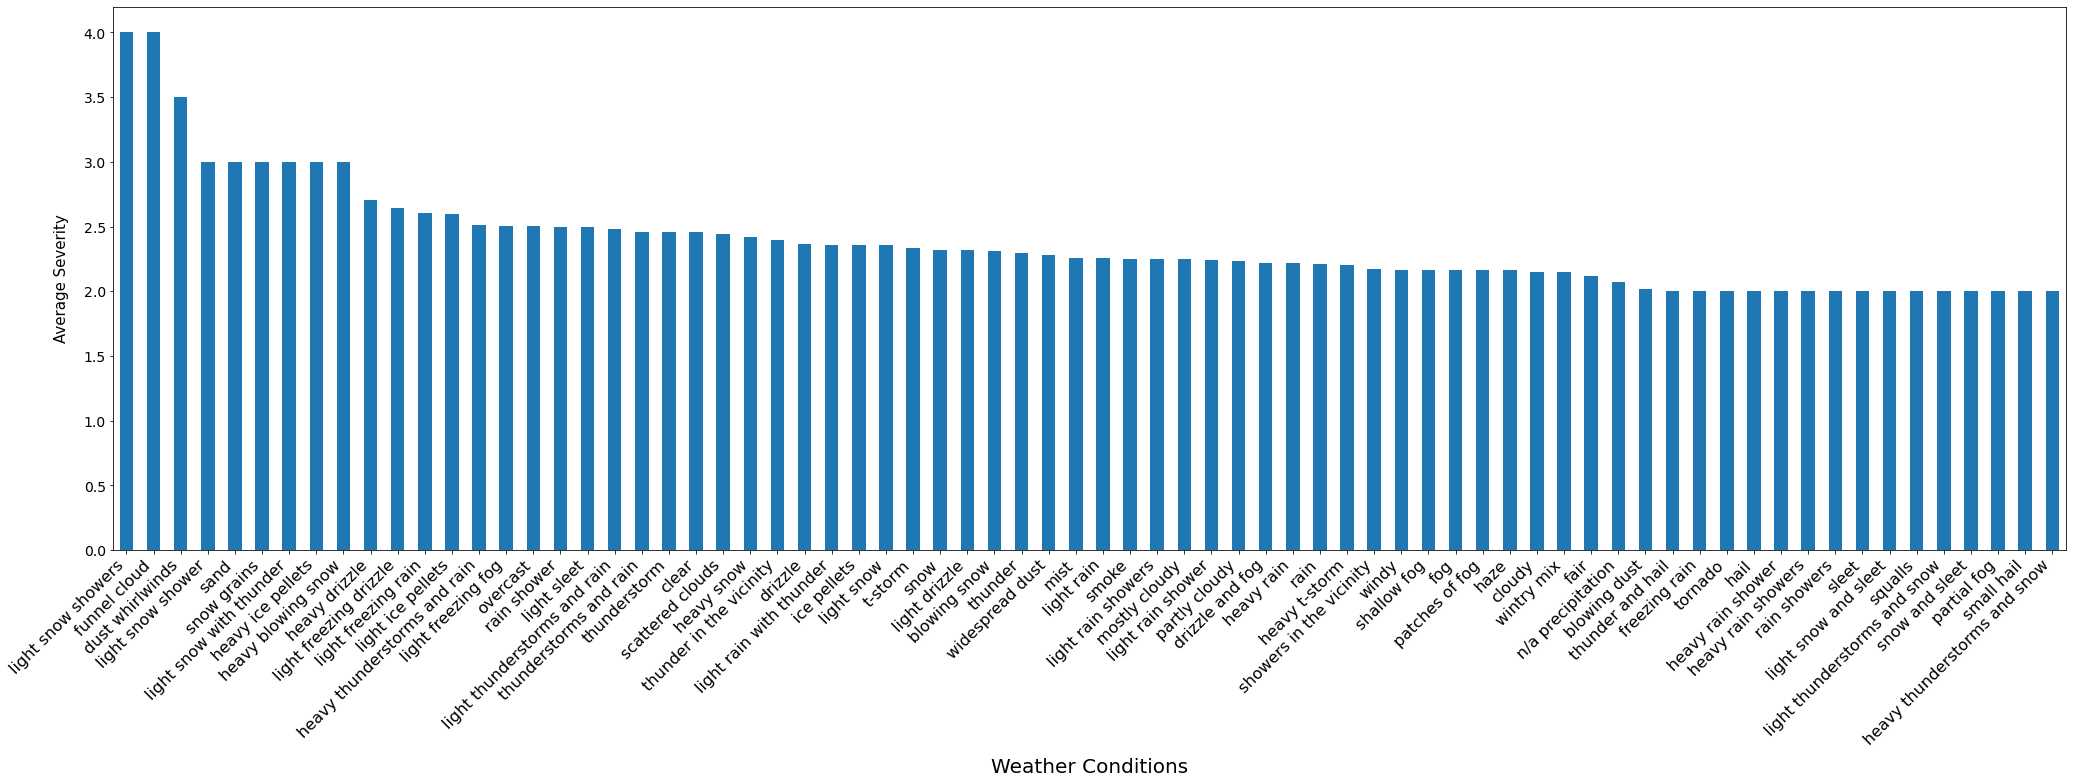

In [149]:
xlabels = graph3_df["Severity"].index
ylabels = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]

ax = graph3_df.sort_values(by="Severity", ascending=False).plot.bar(figsize=(35,10))
ax.set_xlabel('Weather Conditions', fontsize=20, labelpad=10)
ax.set_ylabel('Average Severity', fontsize=15, labelpad=15)
ax.set_xticklabels(labels=xlabels, rotation=45, horizontalalignment='right', fontsize=16)
ax.set_yticks(ylabels)
ax.set_yticklabels(labels=ylabels, fontsize=14)
ax.get_legend().remove()
ax

* This graph is made with the `Severity` and `Weather_Condition` columns. The weather conditions are split up from their original category for lesser bars in the graph, which makes it a lot easier to read without changing the hypothesis much. Then, for each weather condition, the severity of each accident is averaged out.
* From the graph, we can see that weather conditions don't actually affect accident severities in a certain way. Common sense would say that accidents happening during snow or rain would be very severe and vice versa for dry and fair weather. But from the graph above, we can see that snows and rains can have anywhere from being the lowest to the highest of severities, no particular trend can be seen. The same for other types of weather as well. From this, we can build up a hypothesis that maybe weather conditions don't have that much of an effect onto the severity of accidents, since the average severities are so spread out among various weather conditions, maybe something else has a larger effect on how severe an accident is.

# Task 2: Feature Engineering

* For the first part of feature engineering, we will check the correlation between columns and with the label `Severity`

In [150]:
from sklearn.preprocessing import LabelEncoder

# using different dataframes for feature engineering, saving the cleaned dataframe just in case
# dropping the geometry column created while building graph 2 for train dataframe
feat_train = train_df.drop("geometry", axis=1)

# temporarily use LabelEncoder to convert string columns to int for correlation analysis
le = LabelEncoder()

str_cols = [c for c in feat_train.columns if feat_train[c].dtype == 'string']

feat_train[str_cols] = feat_train[str_cols].apply(le.fit_transform)

# convert boolean columns to int as well
for col in feat_train.columns:
    if feat_train[col].dtype == 'bool':
        feat_train[col] = feat_train[col].astype('int')

In [151]:
# generate the correlation matrix
corr = feat_train.corr()

Text(0.5, 1.0, 'Correlations between features')

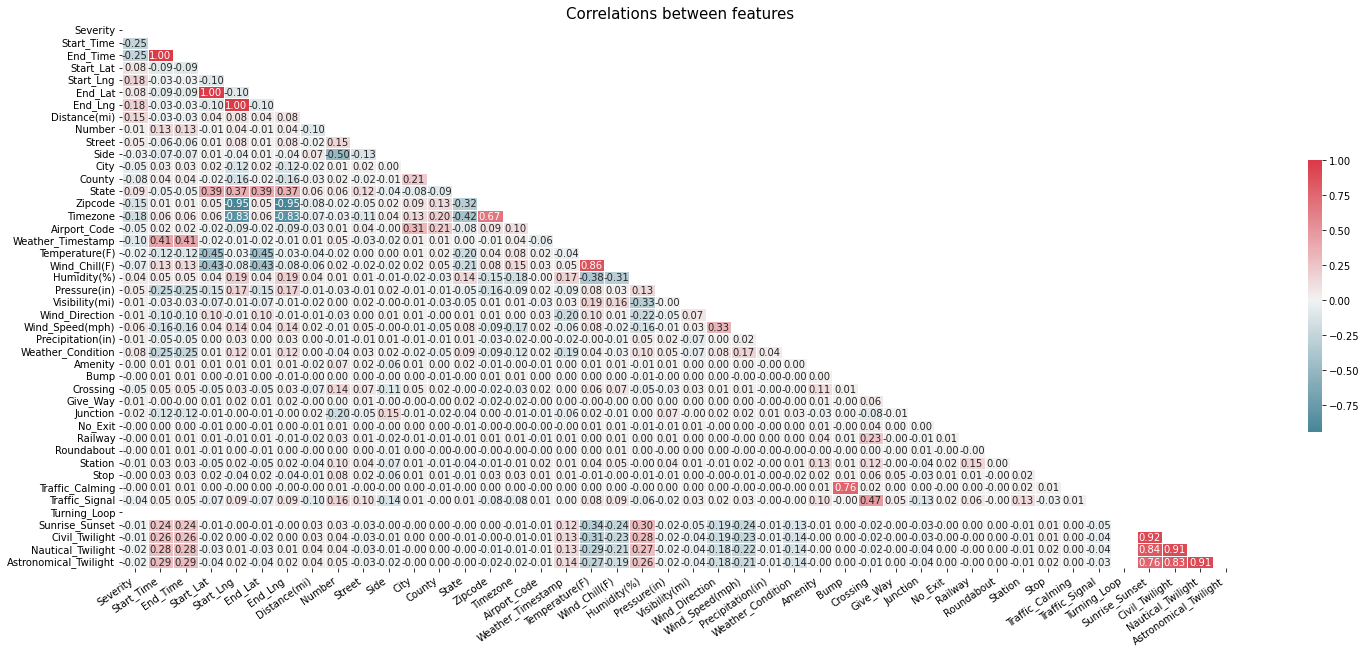

In [152]:
# graph out the correlation matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap = True)

ax = plt.figure(figsize=(25, 10))
ax = sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f', mask = mask, vmax = 1, center = 0, linewidths = .5, cbar_kws = {"shrink": .5})
ax = plt.xticks(rotation=35, horizontalalignment='right')
ax = plt.title("Correlations between features", fontsize=15)
ax

In [153]:
# That's a lot of columns and numbers, let's rank the correlation against our label 'Severity'
abs_corrs = []
corr_cols = feat_train.drop('Severity', axis=1).columns

for var in corr_cols:
    abs_corrs.append(abs(feat_train['Severity'].corr(feat_train[var])))

corrs_df = pd.DataFrame([corr_cols, abs_corrs], index=['Column', 'Correlation']).T.sort_values('Correlation', ascending=False)
corrs_df

,Column,Correlation
0,Start_Time,0.25315
1,End_Time,0.253008
14,Timezone,0.181146
3,Start_Lng,0.179406
5,End_Lng,0.179405
6,Distance(mi),0.154603
13,Zipcode,0.14815
16,Weather_Timestamp,0.103747
12,State,0.094326
25,Weather_Condition,0.080027


* From the correlation analysis above, we can make some decisions regarding certain columns.
* If we look at `Traffic_Signal` and `Side`, the correlation drop off is very high and sudden, not gradually unlike other columns (0.044 -> 0.02), so we will take 0.04 as the divider between "highly" correlated columns and anything lower as low correlation.
* Low correlation columns will be dropped from the dataframes and high correlation columns will be kept for further preprocessing before going into modelling.
* We can try to adjust the cut-off later and see if the numbers are better or worse.

In [154]:
low_corrs = corrs_df[corrs_df["Correlation"] < 0.04]["Column"].to_numpy()
# add this manually because it's a NaN
low_corrs = np.append(low_corrs, "Turning_Loop")

high_corrs = corrs_df[corrs_df["Correlation"] > 0.04]["Column"].to_numpy()

print(f"Low correlation columns:\n {', '.join(low_corrs)}\n")
print(f"High correlation columns:\n {', '.join(high_corrs)}")

Low correlation columns:
 Side, Junction, Astronomical_Twilight, Temperature(F), Nautical_Twilight, Civil_Twilight, Sunrise_Sunset, Precipitation(in), Station, Number, Wind_Direction, Give_Way, Visibility(mi), Railway, Bump, Amenity, Traffic_Calming, No_Exit, Stop, Roundabout, Turning_Loop

High correlation columns:
 Start_Time, End_Time, Timezone, Start_Lng, End_Lng, Distance(mi), Zipcode, Weather_Timestamp, State, Weather_Condition, End_Lat, Start_Lat, County, Wind_Chill(F), Wind_Speed(mph), Crossing, Pressure(in), Street, City, Airport_Code, Humidity(%), Traffic_Signal


In [155]:
# reset the temporary dataframe to the cleaned dataframe but just with high correlation columns now
feat_train = train_df[np.append(["Severity"], high_corrs)]
feat_val = val_df[np.append(["Severity"], high_corrs)]
feat_test = test_df[high_corrs]

In [156]:
feat_train.select_dtypes('string').nunique()

Timezone                 4
Zipcode              83287
State                   49
Weather_Condition      102
County                1522
Street               45124
City                  8855
Airport_Code          1885
dtype: int64

* Even though these columns are categorical, the number of unique values of some columns is simply too high to be one hot encoded, the amount of columns generated would resulted in very high memory consumption, so it's not feasible to one hot encode qthese columns
* So, what we will try to do is something called Frequency Encoding, where we encode the value as their frequency instead. This will be applied on `Zipcode`, `State`, `Weather_Condition`, `County`, `City`, `Airport_Code` because of their high amount of unique values.
* `Timezone` will be one hot encoded because of its low amounts of unique categorical values.
* For `Street` we will do something else later to make it useful.

In [157]:
# frequency encoding for high unique value count columns
freq_cols = ['Zipcode', 'State', 'Weather_Condition', 'County', 'City', 'Airport_Code']

for col in freq_cols:
    for df in [feat_train, feat_val, feat_test]:
        freq = df.groupby(col).size() / len(df)
        df[f"{col}_freq"] = df[col].apply(lambda x : freq[x])

In [158]:
# we don't need the old columns anymore now
feat_train = feat_train.drop(freq_cols, axis=1)
feat_val = feat_val.drop(freq_cols, axis=1)
feat_test = feat_test.drop(freq_cols, axis=1)

In [159]:
# convert boolean columns to int
for col in feat_train.columns:
    if feat_train[col].dtype == 'bool':
        feat_train[col] = feat_train[col].astype('int')
        feat_val[col] = feat_val[col].astype('int')
        feat_test[col] = feat_test[col].astype('int')

In [160]:
# quick sanity check before moving on
feat_train.head(5)

,Severity,Start_Time,End_Time,Timezone,Start_Lng,End_Lng,Distance(mi),Weather_Timestamp,End_Lat,Start_Lat,...,Pressure(in),Street,Humidity(%),Traffic_Signal,Zipcode_freq,State_freq,Weather_Condition_freq,County_freq,City_freq,Airport_Code_freq
0,2,1.608188e+09,1.608226e+09,US/Eastern,-80.188672,-80.190011,0.148,1.608188e+09,25.941481,25.939703,...,30.01,ne 6th ave,74.0,0,0.000068,0.102067,0.126824,0.031478,0.024089,0.005519
1,4,1.493278e+09,1.493300e+09,US/Central,-89.324430,-89.324640,0.467,1.493278e+09,43.190950,43.197700,...,29.57,us-51 s,76.0,0,0.000031,0.005264,0.057794,0.000563,0.000031,0.000416
2,2,1.609176e+09,1.609182e+09,US/Pacific,-117.880283,-117.880314,0.419,1.609178e+09,33.922082,33.928147,...,29.86,ca-57 s,74.0,0,0.000534,0.295478,0.336006,0.033277,0.000552,0.010982
3,2,1.573548e+09,1.573555e+09,US/Mountain,-111.953630,-111.953630,0.000,1.573549e+09,40.717830,40.717830,...,25.83,i-215 s,29.0,0,0.000550,0.021831,0.126824,0.010004,0.001350,0.006589
4,2,1.578659e+09,1.578673e+09,US/Pacific,-123.725830,-123.725830,0.000,1.578660e+09,44.008170,44.008170,...,29.52,highway 126,83.0,0,0.000024,0.057656,0.011446,0.004054,0.000161,0.004604


* For `Street`, we can try to see if the type of street, i.e. Avenue, Highway, Road, etc., have any correlation with the `Severity` of the accidents.

In [161]:
# using this library to extract street type from address
import usaddress

def parse_addr(addr):
    comps = usaddress.parse(addr)
    for c in comps:
        if c[1] == 'StreetNamePostType':
            return c[0]

    return ''


str_type_df = feat_train[['Severity', 'Street']]
str_type_df["Street"] = str_type_df["Street"].apply(parse_addr)

str_type_df["Street"]

0         ave
1            
2            
3            
4            
         ... 
454814     st
454815       
454816    fwy
454817     st
454818       
Name: Street, Length: 454819, dtype: object

In [162]:
str_type_df["Street"].value_counts().head(25)

              246135
rd             47047
ave            30086
fwy            27901
st             27566
blvd           17036
hwy            12403
dr             10886
expy            9371
pkwy            8304
tpke            3804
ln              2730
pike            1929
way             1559
trl             1530
brg             1032
highway          859
trwy             653
pl               599
byp              480
expressway       404
cir              347
ct               289
ter              274
loop             235
Name: Street, dtype: int64

* We see that a Highway street type is denoted both as `hwy` and `highway`. Same for Expressway as `expy` and `expressway`.
* Doing some Googling and I found out that this is a standard suffix abbreviation in America and [USPS](https://pe.usps.com/text/pub28/28apc_002.htm) has a table of street type names and their abbreviations.
* Since we don't know how many more street types have the same issue as Highway and Expressway, we will scrape the abbreviation table from USPS and build a dictionary to convert all the values into their respective abbreviation.

In [163]:
# get the replace dictionary from another python helper file
replace_d = get_street_types()

str_type_df["Street"] = str_type_df["Street"].replace(replace_d)
str_type_df["Street"].value_counts().head(25)

        246135
rd       47071
ave      30109
fwy      28027
st       27597
blvd     17050
hwy      13262
dr       10889
expy      9816
pkwy      8354
tpke      3804
ln        2731
pike      1929
way       1559
trl       1534
brg       1110
trwy       653
pl         599
byp        481
cir        350
ct         289
ter        275
loop       235
cswy       131
aly        110
Name: Street, dtype: int64

* Highway and Expressway are now abbreviated, hope other types are too.

<AxesSubplot:>

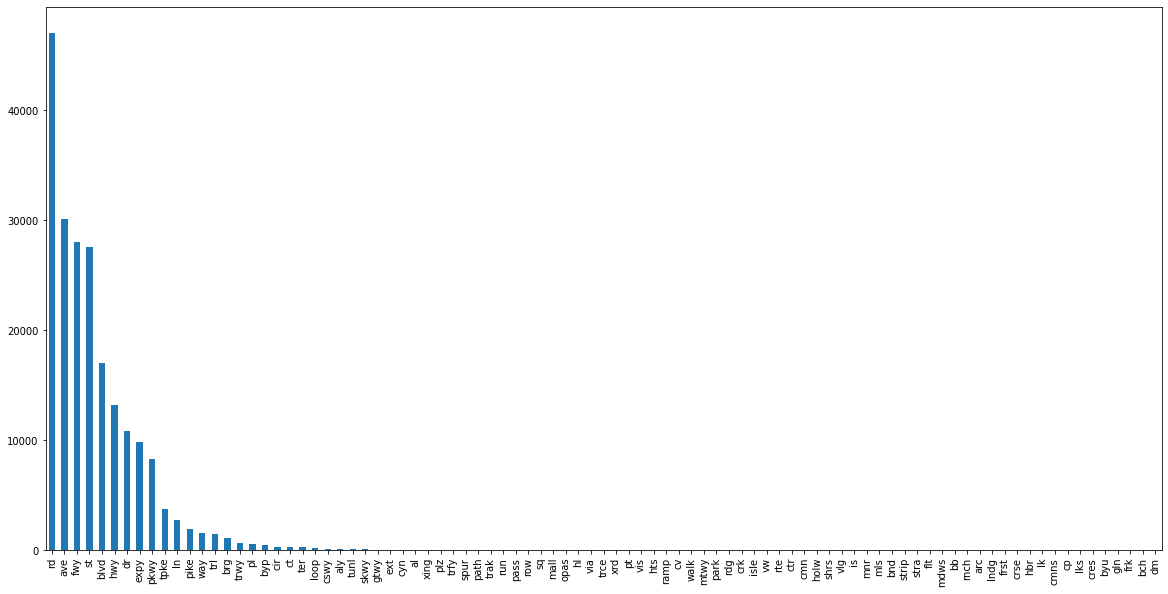

In [164]:
# excepting the none street type, let's see the distribution of street types
str_type_df["Street"].value_counts().iloc[1:].plot.bar(figsize=(20, 10))

* From the graph above, I think we can keep the first 6 as feature for the main dataframe.
* The drop from Parkway (`pkwy`) to Turnpike (`tpke`) seems very big and sudden, not gradual. So we'll set Parkway (`pkwy`) as the cut-off point

In [165]:
str_types = ['rd', 'ave', 'fwy', 'st', 'blvd', 'hwy', 'dr', 'expy', 'pkwy']

# if not one of the 9 street types, set them to an empty string
str_type_df["Street"] = str_type_df["Street"].where(str_type_df["Street"].isin(str_types), '')

str_type_df["Street"].value_counts()

        262644
rd       47071
ave      30109
fwy      28027
st       27597
blvd     17050
hwy      13262
dr       10889
expy      9816
pkwy      8354
Name: Street, dtype: int64

In [166]:
# let's also do frequency encoding for this one
freq = str_type_df.groupby('Street').size() / len(str_type_df)
str_type_df["Street_freq"] = str_type_df['Street'].apply(lambda x : freq[x])
str_type_df

,Severity,Street,Street_freq
0,2,ave,0.066200
1,4,,0.577469
2,2,,0.577469
3,2,,0.577469
4,2,,0.577469
...,...,...,...
454814,2,st,0.060677
454815,2,,0.577469
454816,4,fwy,0.061622
454817,2,st,0.060677


In [167]:
feat_train["Street_freq"] = str_type_df["Street_freq"]
feat_train = feat_train.drop("Street", axis=1)
feat_train

,Severity,Start_Time,End_Time,Timezone,Start_Lng,End_Lng,Distance(mi),Weather_Timestamp,End_Lat,Start_Lat,...,Pressure(in),Humidity(%),Traffic_Signal,Zipcode_freq,State_freq,Weather_Condition_freq,County_freq,City_freq,Airport_Code_freq,Street_freq
0,2,1.608188e+09,1.608226e+09,US/Eastern,-80.188672,-80.190011,0.148,1.608188e+09,25.941481,25.939703,...,30.010000,74.0,0,0.000068,0.102067,0.126824,0.031478,0.024089,0.005519,0.066200
1,4,1.493278e+09,1.493300e+09,US/Central,-89.324430,-89.324640,0.467,1.493278e+09,43.190950,43.197700,...,29.570000,76.0,0,0.000031,0.005264,0.057794,0.000563,0.000031,0.000416,0.577469
2,2,1.609176e+09,1.609182e+09,US/Pacific,-117.880283,-117.880314,0.419,1.609178e+09,33.922082,33.928147,...,29.860000,74.0,0,0.000534,0.295478,0.336006,0.033277,0.000552,0.010982,0.577469
3,2,1.573548e+09,1.573555e+09,US/Mountain,-111.953630,-111.953630,0.000,1.573549e+09,40.717830,40.717830,...,25.830000,29.0,0,0.000550,0.021831,0.126824,0.010004,0.001350,0.006589,0.577469
4,2,1.578659e+09,1.578673e+09,US/Pacific,-123.725830,-123.725830,0.000,1.578660e+09,44.008170,44.008170,...,29.520000,83.0,0,0.000024,0.057656,0.011446,0.004054,0.000161,0.004604,0.577469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454814,2,1.589968e+09,1.589970e+09,US/Eastern,-85.664750,-85.665340,1.010,1.589968e+09,42.898620,42.884010,...,29.180000,41.0,1,0.000147,0.018227,0.336006,0.003010,0.002128,0.002537,0.060677
454815,2,1.604693e+09,1.604713e+09,US/Eastern,-72.841665,-72.875173,4.311,2.407049e+09,41.392975,41.450085,...,29.557892,93.0,0,0.000081,0.009975,0.336006,0.002291,0.000101,0.001027,0.577469
454816,4,1.495666e+09,1.495688e+09,US/Pacific,-117.361640,-117.363180,0.109,1.495666e+09,33.996280,33.995360,...,29.810000,87.0,0,0.000890,0.295478,0.057794,0.016121,0.005426,0.007322,0.061622
454817,2,1.484823e+09,1.484844e+09,US/Pacific,-121.744312,-121.744326,0.001,1.484823e+09,36.755572,36.755561,...,29.900000,77.0,0,0.000117,0.295478,0.119366,0.002891,0.000193,0.001658,0.060677


In [168]:
# same thing for validation and testing set
feat_val["Street"] = feat_val["Street"].apply(parse_addr)
feat_test["Street"] = feat_test["Street"].apply(parse_addr)

In [169]:
feat_val["Street"] = feat_val["Street"].replace(replace_d)
feat_test["Street"] = feat_test["Street"].replace(replace_d)

In [170]:
feat_val["Street"] = feat_val["Street"].where(feat_val["Street"].isin(str_types), '')
feat_test["Street"] = feat_test["Street"].where(feat_test["Street"].isin(str_types), '')

In [171]:
for df in [feat_val, feat_test]:
    freq = df.groupby('Street').size() / len(df)
    df[f"{'Street'}_freq"] = df['Street'].apply(lambda x : freq[x])

In [172]:
feat_val = feat_val.drop("Street", axis=1)
feat_test = feat_test.drop("Street", axis=1)

In [173]:
feat_val.head(3)

,Severity,Start_Time,End_Time,Timezone,Start_Lng,End_Lng,Distance(mi),Weather_Timestamp,End_Lat,Start_Lat,...,Pressure(in),Humidity(%),Traffic_Signal,Zipcode_freq,State_freq,Weather_Condition_freq,County_freq,City_freq,Airport_Code_freq,Street_freq
0,2,1.608822e+09,1.608832e+09,US/Central,-98.396312,-98.401992,1.785,1.608822e+09,29.491863,29.517217,...,29.49,23.0,0,0.000046,0.050005,0.333727,0.002698,0.002579,0.000277,0.578176
1,3,1.514044e+09,1.514066e+09,US/Pacific,-122.673590,-122.678580,0.549,1.514044e+09,45.487430,45.494570,...,30.38,59.0,0,0.000270,0.058217,0.129856,0.009169,0.009815,0.007084,0.578176
2,4,1.540024e+09,1.540026e+09,US/Eastern,-84.548020,-84.548030,0.130,1.540024e+09,42.700873,42.702751,...,29.72,89.0,0,0.000007,0.018311,0.011444,0.000475,0.000561,0.000613,0.059404


* Before we continue with one hot encoding and other stuff. We will extract out the year, month, weekday, day and hour from the `Start_Time` timestamp.
* From the Data Exploration part, we saw that the hour and weekday have a special pattern and it may potentially impact the performance of the model if we extract them back out. While we're at it, let's also extract other info as well

In [174]:
# temporarily convert the timestamp into a datetime object, remember to drop this later
feat_train["start_dt"] = pd.to_datetime(feat_train["Start_Time"], unit='s')
feat_val["start_dt"] = pd.to_datetime(feat_val["Start_Time"], unit='s')
feat_test["start_dt"] = pd.to_datetime(feat_test["Start_Time"], unit='s')

In [175]:
# extracting hour from timestamp
feat_train["hour"] = feat_train["start_dt"].apply(lambda x : x.time().hour)
feat_val["hour"] = feat_val["start_dt"].apply(lambda x : x.time().hour)
feat_test["hour"] = feat_test["start_dt"].apply(lambda x : x.time().hour)

In [176]:
# extracting weekday from timestamp
feat_train["weekday"] = feat_train["start_dt"].apply(lambda x : x.weekday())
feat_val["weekday"] = feat_val["start_dt"].apply(lambda x : x.weekday())
feat_test["weekday"] = feat_test["start_dt"].apply(lambda x : x.weekday())

In [177]:
# extracting day of month from timestamp
feat_train["day"] = feat_train["start_dt"].apply(lambda x : x.day)
feat_val["day"] = feat_val["start_dt"].apply(lambda x : x.day)
feat_test["day"] = feat_test["start_dt"].apply(lambda x : x.day)

In [178]:
# extracting month from timestamp
feat_train["month"] = feat_train["start_dt"].apply(lambda x : x.month)
feat_val["month"] = feat_val["start_dt"].apply(lambda x : x.month)
feat_test["month"] = feat_test["start_dt"].apply(lambda x : x.month)

In [179]:
# extracting year from timestamp
feat_train["year"] = feat_train["start_dt"].apply(lambda x : x.year)
feat_val["year"] = feat_val["start_dt"].apply(lambda x : x.year)
feat_test["year"] = feat_test["start_dt"].apply(lambda x : x.year)

* Let's also try to extract the duration of accidents by taking the delta between `End_Time` and `Start_Time`

In [180]:
# temporarily convert the timestamp into a datetime object, remember to drop this later
feat_train["end_dt"] = pd.to_datetime(feat_train["End_Time"], unit='s')
feat_val["end_dt"] = pd.to_datetime(feat_val["End_Time"], unit='s')
feat_test["end_dt"] = pd.to_datetime(feat_test["End_Time"], unit='s')

In [181]:
feat_train["duration"] = feat_train["end_dt"] - feat_train["start_dt"]
feat_val["duration"] = feat_val["end_dt"] - feat_val["start_dt"]
feat_test["duration"] = feat_test["end_dt"] - feat_test["start_dt"]

In [182]:
feat_train["duration"] = feat_train["duration"] / np.timedelta64(1, 'm')
feat_val["duration"] = feat_val["duration"] / np.timedelta64(1, 'm')
feat_test["duration"] = feat_test["duration"] / np.timedelta64(1, 'm')

In [183]:
feat_train = feat_train.drop(["start_dt", "end_dt"], axis=1)
feat_val = feat_val.drop(["start_dt", "end_dt"], axis=1)
feat_test = feat_test.drop(["start_dt", "end_dt"], axis=1)

* We can take the chance here to check for multicollinearity between columns and see how it is

In [184]:
# checking for multicollinearity
# credits: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/#h2_3

import statsmodels.api as sm

def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

In [185]:
# dropping the label, and Timezone while checking because it's still a string
calculate_vif(feat_train.drop(["Severity", "Timezone"], axis=1))

C:\Users\hntuy\AppData\Local\Temp/ipykernel_20940/1660408764.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
0,Start_Time,inf
1,End_Time,inf
26,duration,inf
3,End_Lng,604345.90
2,Start_Lng,604339.37
7,Start_Lat,93208.73
6,End_Lat,93204.93
15,State_freq,3.57
19,Airport_Code_freq,2.38
17,County_freq,2.14


* Very high multicollinearity between the `Start_` and `End_` columns, which is pretty much expected
* Let's try to drop the `End_` ones and see if the VIF is lower

In [186]:
calculate_vif(feat_train.drop(["Severity", "Timezone", "End_Lng", "End_Lat", "End_Time"], axis=1))

,Var,Vif
12,State_freq,3.57
1,Start_Lng,2.85
16,Airport_Code_freq,2.38
14,County_freq,2.14
4,Start_Lat,1.80
0,Start_Time,1.70
15,City_freq,1.69
13,Weather_Condition_freq,1.53
9,Humidity(%),1.48
11,Zipcode_freq,1.45


* Much better now, so let's drop them from the dataframes

In [187]:
feat_train = feat_train.drop(["End_Lng", "End_Lat", "End_Time"], axis=1)
feat_val = feat_val.drop(["End_Lng", "End_Lat", "End_Time"], axis=1)
feat_test = feat_test.drop(["End_Lng", "End_Lat", "End_Time"], axis=1)

In [188]:
# now let's one hot encode the Timezone

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
# fit and transform the encoder
enc_train = ohe.fit_transform(feat_train['Timezone'].to_numpy().reshape(-1, 1)).toarray()
enc_val = ohe.fit_transform(feat_val['Timezone'].to_numpy().reshape(-1, 1)).toarray()
enc_test = ohe.fit_transform(feat_test['Timezone'].to_numpy().reshape(-1, 1)).toarray()

# put them into columns
train_ohe_df = pd.DataFrame(enc_train, columns=[f"Timezone_{i}" for i in range(enc_train.shape[1])])
val_ohe_df = pd.DataFrame(enc_val, columns=[f"Timezone_{i}" for i in range(enc_val.shape[1])])
test_ohe_df = pd.DataFrame(enc_test, columns=[f"Timezone_{i}" for i in range(enc_test.shape[1])])

In [189]:
train_ohe_df.head(3)

,Timezone_0,Timezone_1,Timezone_2,Timezone_3
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0


In [190]:
# concatenate them with the dataframes and drop the original column as well
feat_train = pd.concat([feat_train.drop("Timezone", axis=1), train_ohe_df], axis=1)
feat_val = pd.concat([feat_val.drop("Timezone", axis=1), val_ohe_df], axis=1)
feat_test = pd.concat([feat_test.drop("Timezone", axis=1), test_ohe_df], axis=1)

In [191]:
# last sanity checks before going into modeling
feat_train.head(3)

,Severity,Start_Time,Start_Lng,Distance(mi),Weather_Timestamp,Start_Lat,Wind_Chill(F),Wind_Speed(mph),Crossing,Pressure(in),...,hour,weekday,day,month,year,duration,Timezone_0,Timezone_1,Timezone_2,Timezone_3
0,2,1.608188e+09,-80.188672,0.148,1.608188e+09,25.939703,81.0,12.0,0,30.01,...,6,3,17,12,2020,624.766667,0.0,1.0,0.0,0.0
1,4,1.493278e+09,-89.324430,0.467,1.493278e+09,43.197700,37.1,8.1,0,29.57,...,7,3,27,4,2017,360.000000,1.0,0.0,0.0,0.0
2,2,1.609176e+09,-117.880283,0.419,1.609178e+09,33.928147,44.0,7.0,0,29.86,...,17,0,28,12,2020,98.616667,0.0,0.0,0.0,1.0


In [192]:
feat_train.dtypes

Severity                    int64
Start_Time                float64
Start_Lng                 float64
Distance(mi)              float64
Weather_Timestamp         float64
Start_Lat                 float64
Wind_Chill(F)             float64
Wind_Speed(mph)           float64
Crossing                    int32
Pressure(in)              float64
Humidity(%)               float64
Traffic_Signal              int32
Zipcode_freq              float64
State_freq                float64
Weather_Condition_freq    float64
County_freq               float64
City_freq                 float64
Airport_Code_freq         float64
Street_freq               float64
hour                        int64
weekday                     int64
day                         int64
month                       int64
year                        int64
duration                  float64
Timezone_0                float64
Timezone_1                float64
Timezone_2                float64
Timezone_3                float64
dtype: object

In [193]:
feat_val.head(3)

,Severity,Start_Time,Start_Lng,Distance(mi),Weather_Timestamp,Start_Lat,Wind_Chill(F),Wind_Speed(mph),Crossing,Pressure(in),...,hour,weekday,day,month,year,duration,Timezone_0,Timezone_1,Timezone_2,Timezone_3
0,2,1.608822e+09,-98.396312,1.785,1.608822e+09,29.517217,42.0,9.0,0,29.49,...,15,3,24,12,2020,155.000000,1.0,0.0,0.0,0.0
1,3,1.514044e+09,-122.673590,0.549,1.514044e+09,45.494570,23.0,18.4,0,30.38,...,15,5,23,12,2017,360.000000,0.0,0.0,0.0,1.0
2,4,1.540024e+09,-84.548020,0.130,1.540024e+09,42.702751,29.3,19.6,0,29.72,...,8,5,20,10,2018,29.616667,0.0,1.0,0.0,0.0


In [194]:
feat_test.head(3)

,Start_Time,Start_Lng,Distance(mi),Weather_Timestamp,Start_Lat,Wind_Chill(F),Wind_Speed(mph),Crossing,Pressure(in),Humidity(%),...,hour,weekday,day,month,year,duration,Timezone_0,Timezone_1,Timezone_2,Timezone_3
0,1.608030e+09,-117.780277,2.615,1.608030e+09,33.708096,63.0,0.0,0,30.11,40.0,...,11,1,15,12,2020,569.000000,0.0,0.0,0.0,1.0
1,1.569409e+09,-122.403812,0.000,1.569409e+09,37.660428,87.0,18.0,0,29.70,29.0,...,10,2,25,9,2019,81.750000,0.0,0.0,0.0,1.0
2,1.604664e+09,-111.351367,0.060,1.604664e+09,45.647664,45.0,0.0,0,25.18,68.0,...,11,4,6,11,2020,155.216667,0.0,0.0,1.0,0.0


# Task 3: Modelling

In [195]:
import xgboost
from sklearn import linear_model
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn import neural_network
import lightgbm as lgb

In [231]:
train_y = feat_train["Severity"]
train_x = feat_train.drop("Severity", axis=1)
val_y = feat_val["Severity"]
val_x = feat_val.drop("Severity", axis=1)
test_x = feat_test

In [232]:
rs = RobustScaler()
ss = StandardScaler()
qt = QuantileTransformer()

train_x = rs.fit_transform(train_x)
val_x = rs.fit_transform(val_x)
test_x = rs.fit_transform(test_x)

In [233]:
rf = ensemble.RandomForestRegressor(random_state=42)

# rf_model = rf.fit(train_x, train_y)

In [ ]:
rf_pred_train = rf_model.predict(train_x)
rf_pred_val = rf_model.predict(val_x)
rf_pred_test = rf_model.predict(test_x)

In [234]:
nn = neural_network.MLPRegressor(random_state=42)

# nn_model = nn.fit(train_x, train_y)

In [ ]:
nn_pred_train = nn_model.predict(train_x)
nn_pred_val = nn_model.predict(val_x)
nn_pred_test = nn_model.predict(test_x)

In [235]:
lgbmr = lgb.LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=50, num_leaves=75)

# lgbm_model = lgbmr.fit(train_x, train_y)

In [ ]:
lgbm_pred_train = lgbm_model.predict(train_x)
lgbm_pred_val = lgbm_model.predict(val_x)
lgbm_pred_test = lgbm_model.predict(test_x)

In [236]:
# CV best param: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 50}
xgblr = xgboost.XGBRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=50)

# cv = GridSearchCV(estimator=xgblr, param_grid={
#     "n_estimators": [30, 40, 50],
#     "max_depth": [7, 9, 12],
#     "learning_rate": [0.3, 0.5, 0.7]
# }, scoring="neg_root_mean_squared_error", n_jobs=7)

# xgb_model = xgblr.fit(train_x, train_y)

# model = cv.fit(train_x,train_y)

In [ ]:
xgb_pred_train = xgb_model.predict(train_x)
xgb_pred_val = xgb_model.predict(val_x)
xgb_pred_test = xgb_model.predict(test_x)

In [237]:
elnet = linear_model.ElasticNet(random_state=42, alpha=0.001, l1_ratio=0.1)

# CV best param: {'alpha': 0.001, 'l1_ratio': 0.1}
# cv = GridSearchCV(estimator=elnet, param_grid={
#     "l1_ratio": [0.1, 0.5, 0.9],
#     "alpha": [0.001, 0.1, 1]
# }, scoring="neg_root_mean_squared_error", n_jobs=-1)

# elnet_model = elnet.fit(train_x, train_y)

In [ ]:
elnet_pred_train = elnet_model.predict(train_x)
elnet_pred_val = elnet_model.predict(val_x)
elnet_pred_test = elnet_model.predict(test_x)

In [238]:
ridge = linear_model.Ridge(random_state=42)

# ridge_model = ridge.fit(train_x, train_y)

In [ ]:
ridge_pred_train = ridge_model.predict(train_x)
ridge_pred_val = ridge_model.predict(val_x)
ridge_pred_test = ridge_model.predict(test_x)

In [239]:
lasso = linear_model.Lasso(random_state=42)

# lasso_model = lasso.fit(train_x, train_y)

In [ ]:
lasso_pred_train = lasso_model.predict(train_x)
lasso_pred_val = lasso_model.predict(val_x)
lasso_pred_test = lasso_model.predict(test_x)

In [ ]:
train_x_stack = np.stack((rf_pred_train, nn_pred_train, lgbm_pred_train, xgb_pred_train, elnet_pred_train, ridge_pred_train, lasso_pred_train)).T
val_x_stack = np.stack((rf_pred_val, nn_pred_val, lgbm_pred_val, xgb_pred_val, elnet_pred_val, ridge_pred_val, lasso_pred_val)).T
test_x_stack = np.stack((rf_pred_test, nn_pred_test, lgbm_pred_test, xgb_pred_test, elnet_pred_test, ridge_pred_test, lasso_pred_test)).T

In [ ]:
stack_model = xgblr.fit(train_x_stack, train_y)

In [ ]:
pred = stack_model.predict(val_x_stack)

In [214]:
pred = lgbm_model.predict(val_x)

In [244]:
rmse = mean_squared_error(val_y, pred, squared=False)
mae = median_absolute_error(val_y, pred)
r2 = r2_score(val_y, pred)

print(f"{rmse=}\n{mae=}\n{r2=}")

rmse=0.4428057935350474
mae=0.05930900573730469
r2=0.46986454658540056


In [245]:
pred = model.predict(test_x)

sub = pd.concat([test_df, pd.DataFrame(pred, columns=["Severity"])], axis=1)

sub = sub[["ID", "Severity"]]

sub.to_csv("submission.csv", index=False)

# MLXTEND

In [217]:
from mlxtend.regressor import StackingCVRegressor

In [240]:
stack = StackingCVRegressor(regressors=[rf, nn, lgbmr, xgblr, elnet, ridge, lasso], meta_regressor=xgblr, random_state=42, n_jobs=-1, verbose=2)

In [241]:
model = stack.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 15.7min remaining: 23.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [242]:
pred = model.predict(val_x)

In [243]:
import pickle

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))